In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
import tensorflow as tf
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

In [9]:
class Fruit:

  def __init__(self, df):
    self.df = df
    self.df = self.df[1:].replace(0, np.NaN)
    self.df = self.df.interpolate().fillna(0)
    # date 열을 Datetime 으로 변환
    self.df.date = pd.to_datetime(self.df.date)
    # 요일을 원핫인코딩
    self.df = pd.concat([self.df, pd.get_dummies(self.df['요일'])], axis=1)
    # date(year-month-day)
    self.df['year'] = self.df['date'].dt.year
    self.df['month'] = self.df['date'].dt.month
    self.df['day'] = self.df['date'].dt.day
    # '포도_거래량(kg)'부터 feature로 선택
    self.feature = self.df.columns[2:]
    # 행 인덱스 초기화
    self.df = self.df.reset_index(drop=True)
    # print("NaN in df:", self.df.isna().sum().sum())
    
    def replace_zero_with_mean(df, column):
        for i in range(len(df)):
            if df[column][i] == 0:
                if i == 0:
                    df.at[i, column] = (df[column][i+1] + df[column][i+2]) / 2
                elif i == len(df) - 1:
                    df.at[i, column] = (df[column][i-1] + df[column][i-2]) / 2
                else:
                    df.at[i, column] = (df[column][i-1] + df[column][i+1]) / 2
    for col in self.df.columns:
        if '_가격(원/kg)' in col:
            replace_zero_with_mean(self.df, col)

  def set_feature(self,name):
    # target의 feature를 설정
    self.name = name
    self.name1 = name+"_가격(원/kg)"
    self.name2 = name+"_거래량(kg)"
    self.feature = [self.name2, 'year', 'month', 'day', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', 'resid']

  def set_target(self,week):
    # 1주 후, 2주 후, 4주 후를 예측하기 위해 target으로 설정
    if week == 1:
      self.df['target'] = self.df[self.name1].shift(-7)
    elif week == 2:
      self.df['target'] = self.df[self.name1].shift(-14)
    elif week == 4:
      self.df['target'] = self.df[self.name1].shift(-28)

    # 분해 시계열의 잔차  
    self.df['resid'] = 0
    stl = STL(self.df[['date', self.name1]].set_index('date'), period=12)
    res = stl.fit()
    self.df['resid'] = res.resid.values

  def set_model(self, timesteps=7):
    self.df.dropna(inplace=True)
    self.x = self.df[self.feature]
    self.y = self.df['target']
    # 스케일링
    self.scaler_x = MinMaxScaler()
    self.scaler_y = MinMaxScaler()
    self.x_scaled = self.scaler_x.fit_transform(self.x)
    self.y = self.y.values.reshape(-1, 1)
    self.y_scaled = self.scaler_y.fit_transform(self.y)
    # 시계열 데이터 형태로 변환
    def create_sequences(data, target, step):
        x_seq, y_seq = [], []
        for i in range(len(data) - step):
            x_seq.append(data[i:i + step])
            y_seq.append(target[i + step])
        return np.array(x_seq), np.array(y_seq)
    self.x_lstm, self.y_lstm = create_sequences(self.x_scaled, self.y_scaled, timesteps)
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x_lstm, self.y_lstm, test_size=0.25, random_state=42)

    self.model = Sequential()
    self.model.add(LSTM(100, return_sequences=True, input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
    self.model.add(Dropout(0.2))
    self.model.add(LSTM(50))
    self.model.add(Dropout(0.2))
    self.model.add(Dense(1, activation='relu'))
    self.model.compile(optimizer='adam', loss='mean_squared_error')
    self.early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    self.model.fit(self.x_train, self.y_train, epochs=1000, batch_size=32, 
                   validation_data=(self.x_test, self.y_test), callbacks=[self.early_stopping], verbose=2)
    
  def get_plot(self):
    self.train_loss = self.model.evaluate(self.x_train, self.y_train)
    self.test_loss = self.model.evaluate(self.x_test, self.y_test)
    print("Train Loss:", self.train_loss)
    print("Test Loss:", self.test_loss)

    self.y_pred_scaled = self.model.predict(self.x_test)
    self.y_pred = self.scaler_y.inverse_transform(self.y_pred_scaled)
    self.y_test_inv = self.scaler_y.inverse_transform(self.y_test)

    self.mae = mean_absolute_error(self.y_test_inv, self.y_pred)
    self.mse = mean_squared_error(self.y_test_inv, self.y_pred)
    self.rmse = np.sqrt(self.mse)
    self.r2 = r2_score(self.y_test_inv, self.y_pred)

    print("Mean Absolute Error (MAE):", self.mae)
    print("Mean Squared Error (MSE):", self.mse)
    print("Root Mean Squared Error (RMSE):", self.rmse)
    print("R² Score:", self.r2)

    # self.train_score = self.model.score(self.x_train, self.y_train)
    # self.test_score = self.model.score(self.x_test, self.y_test)
    # print("Train Score:", self.train_score)
    # print("Test Score:", self.test_score)

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(self.y_test_inv)), self.y_test_inv, label='Real')
    plt.plot(range(len(self.y_pred)), self.y_pred, label='Predict')
    plt.title(self.name + ' 가격 예측 결과'+   '   MAE : ' + str(self.mae)[:7])
    plt.xlabel('Sample Index')
    plt.ylabel(self.name + 'Price(원/kg)')
    plt.legend()
    plt.show()      
  
  # 타겟으로 설정한 품목 가격을 받아오는 코드
  def get_price(self):
    self.last_row_features = self.df[self.feature].iloc[-1].values
    self.last_row_features = self.last_row_features.astype(np.float32)
    self.last_row_features = self.last_row_features.reshape(1, 1, len(self.feature))
    self.price = self.model.predict(self.last_row_features)
    self.price = self.scaler_y.inverse_transform(self.price)
    return self.price[0][0]

In [10]:
df = pd.read_csv('../data/traintest.csv')

In [11]:
my_fruit = Fruit(df)

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


In [12]:
my_fruit.set_feature('사과')

In [13]:
my_fruit.set_target(1)

In [14]:
my_fruit.set_model()

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 9s - 313ms/step - loss: 0.0339 - val_loss: 0.0238
Epoch 2/1000
29/29 - 0s - 14ms/step - loss: 0.0264 - val_loss: 0.0232
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0258 - val_loss: 0.0238
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0261 - val_loss: 0.0222
Epoch 5/1000
29/29 - 0s - 15ms/step - loss: 0.0254 - val_loss: 0.0214
Epoch 6/1000
29/29 - 0s - 14ms/step - loss: 0.0227 - val_loss: 0.0201
Epoch 7/1000
29/29 - 0s - 13ms/step - loss: 0.0208 - val_loss: 0.0171
Epoch 8/1000
29/29 - 0s - 13ms/step - loss: 0.0195 - val_loss: 0.0162
Epoch 9/1000
29/29 - 0s - 14ms/step - loss: 0.0212 - val_loss: 0.0232
Epoch 10/1000
29/29 - 0s - 14ms/step - loss: 0.0215 - val_loss: 0.0172
Epoch 11/1000
29/29 - 0s - 15ms/step - loss: 0.0186 - val_loss: 0.0159
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0184 - val_loss: 0.0166
Epoch 13/1000
29/29 - 0s - 16ms/step - loss: 0.0179 - val_loss: 0.0148
Epoch 14/1000
29/29 - 0s - 16ms/step - loss: 0.0172 - val_loss: 0.0144
Epoch 15/1000


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 
Train Loss: 0.0022019746247678995
Test Loss: 0.0020846580155193806
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Mean Absolute Error (MAE): 196.86771227309842
Mean Squared Error (MSE): 71578.29609793841
Root Mean Squared Error (RMSE): 267.5412044862219
R² Score: 0.9122876544087153


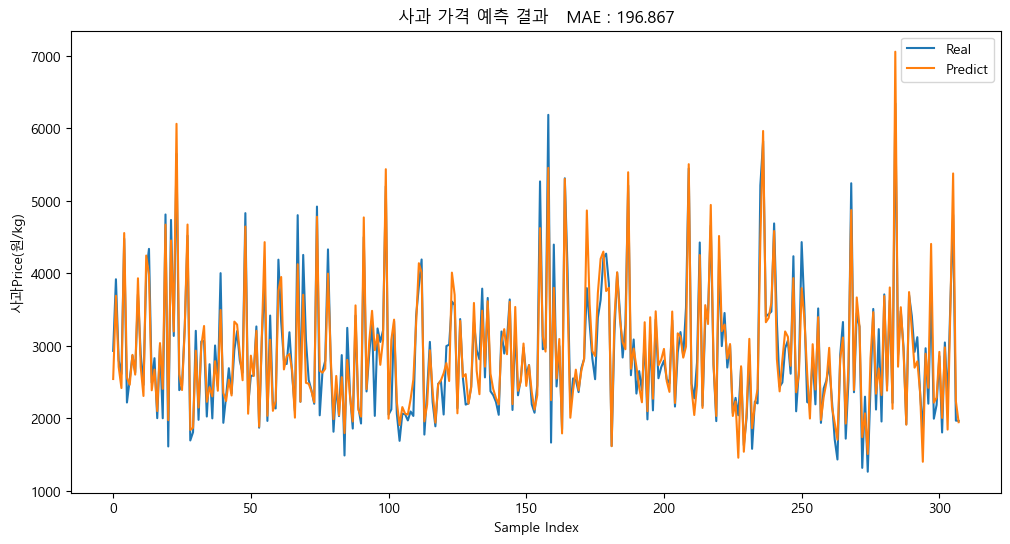

In [15]:
my_fruit.get_plot()

In [16]:
weeks = [1,2,4]
features = ['포도', '망고', '체리', '레몬', '블루베리', '수박' ,'딸기', '메론', 
            '사과', '참외', '감귤', '바나나', '복숭아', '참다래(키위)', '자두', '파인애플' ]

week1=[]
week2=[]
week4=[]

for week in weeks:
  print(week)
  for feature in features:
    my_fruit = Fruit(df)
    my_fruit.set_feature(feature)
    my_fruit.set_target(week)
    my_fruit.set_model()
    if week == 1:
      week1.append(my_fruit.get_price())
    if week == 2:
      week2.append(my_fruit.get_price())
    if week == 4:
      week4.append(my_fruit.get_price())
    print(feature)

1


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 9s - 327ms/step - loss: 0.0573 - val_loss: 0.0311
Epoch 2/1000
29/29 - 2s - 55ms/step - loss: 0.0320 - val_loss: 0.0311
Epoch 3/1000
29/29 - 0s - 12ms/step - loss: 0.0319 - val_loss: 0.0312
Epoch 4/1000
29/29 - 0s - 15ms/step - loss: 0.0293 - val_loss: 0.0334
Epoch 5/1000
29/29 - 1s - 22ms/step - loss: 0.0298 - val_loss: 0.0304
Epoch 6/1000
29/29 - 0s - 13ms/step - loss: 0.0303 - val_loss: 0.0299
Epoch 7/1000
29/29 - 0s - 14ms/step - loss: 0.0298 - val_loss: 0.0302
Epoch 8/1000
29/29 - 0s - 13ms/step - loss: 0.0299 - val_loss: 0.0306
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0297 - val_loss: 0.0321
Epoch 10/1000
29/29 - 0s - 13ms/step - loss: 0.0286 - val_loss: 0.0293
Epoch 11/1000
29/29 - 0s - 12ms/step - loss: 0.0288 - val_loss: 0.0293
Epoch 12/1000
29/29 - 1s - 17ms/step - loss: 0.0279 - val_loss: 0.0298
Epoch 13/1000
29/29 - 1s - 20ms/step - loss: 0.0281 - val_loss: 0.0291
Epoch 14/1000
29/29 - 0s - 13ms/step - loss: 0.0276 - val_loss: 0.0285
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 9s - 324ms/step - loss: 0.0186 - val_loss: 0.0126
Epoch 2/1000
29/29 - 1s - 26ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 3/1000
29/29 - 1s - 18ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 4/1000
29/29 - 0s - 17ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 5/1000
29/29 - 1s - 20ms/step - loss: 0.0097 - val_loss: 0.0090
Epoch 6/1000
29/29 - 1s - 20ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 7/1000
29/29 - 1s - 19ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 8/1000
29/29 - 1s - 22ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 9/1000
29/29 - 1s - 19ms/step - loss: 0.0080 - val_loss: 0.0085
Epoch 10/1000
29/29 - 0s - 17ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 12/1000
29/29 - 0s - 17ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 13/1000
29/29 - 1s - 36ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 14/1000
29/29 - 1s - 38ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 13s - 439ms/step - loss: 0.0424 - val_loss: 0.0272
Epoch 2/1000
29/29 - 0s - 15ms/step - loss: 0.0256 - val_loss: 0.0239
Epoch 3/1000
29/29 - 0s - 15ms/step - loss: 0.0235 - val_loss: 0.0236
Epoch 4/1000
29/29 - 1s - 18ms/step - loss: 0.0225 - val_loss: 0.0229
Epoch 5/1000
29/29 - 1s - 23ms/step - loss: 0.0230 - val_loss: 0.0232
Epoch 6/1000
29/29 - 1s - 23ms/step - loss: 0.0229 - val_loss: 0.0227
Epoch 7/1000
29/29 - 1s - 18ms/step - loss: 0.0224 - val_loss: 0.0230
Epoch 8/1000
29/29 - 1s - 18ms/step - loss: 0.0240 - val_loss: 0.0226
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0227 - val_loss: 0.0225
Epoch 10/1000
29/29 - 0s - 14ms/step - loss: 0.0222 - val_loss: 0.0225
Epoch 11/1000
29/29 - 0s - 14ms/step - loss: 0.0220 - val_loss: 0.0219
Epoch 12/1000
29/29 - 1s - 29ms/step - loss: 0.0221 - val_loss: 0.0231
Epoch 13/1000
29/29 - 1s - 20ms/step - loss: 0.0210 - val_loss: 0.0224
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0218 - val_loss: 0.0221
Epoch 15/1000

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 244ms/step - loss: 0.0299 - val_loss: 0.0138
Epoch 2/1000
29/29 - 0s - 16ms/step - loss: 0.0162 - val_loss: 0.0137
Epoch 3/1000
29/29 - 1s - 25ms/step - loss: 0.0150 - val_loss: 0.0150
Epoch 4/1000
29/29 - 1s - 18ms/step - loss: 0.0145 - val_loss: 0.0153
Epoch 5/1000
29/29 - 1s - 21ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 6/1000
29/29 - 1s - 23ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 7/1000
29/29 - 1s - 21ms/step - loss: 0.0130 - val_loss: 0.0124
Epoch 8/1000
29/29 - 0s - 17ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 9/1000
29/29 - 0s - 14ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 10/1000
29/29 - 0s - 14ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 12/1000
29/29 - 1s - 27ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 13/1000
29/29 - 0s - 15ms/step - loss: 0.0130 - val_loss: 0.0124
Epoch 14/1000
29/29 - 1s - 23ms/step - loss: 0.0117 - val_loss: 0.0127
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 232ms/step - loss: 0.0430 - val_loss: 0.0470
Epoch 2/1000
29/29 - 1s - 20ms/step - loss: 0.0430 - val_loss: 0.0470
Epoch 3/1000
29/29 - 0s - 15ms/step - loss: 0.0430 - val_loss: 0.0470
Epoch 4/1000
29/29 - 1s - 23ms/step - loss: 0.0430 - val_loss: 0.0470
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0430 - val_loss: 0.0470
Epoch 6/1000
29/29 - 1s - 26ms/step - loss: 0.0430 - val_loss: 0.0470
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0430 - val_loss: 0.0470
Epoch 8/1000
29/29 - 1s - 20ms/step - loss: 0.0430 - val_loss: 0.0470
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0430 - val_loss: 0.0470
Epoch 10/1000
29/29 - 1s - 24ms/step - loss: 0.0430 - val_loss: 0.0470
Epoch 11/1000
29/29 - 1s - 23ms/step - loss: 0.0430 - val_loss: 0.0470
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
블루베리


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 239ms/step - loss: 0.0175 - val_loss: 0.0104
Epoch 2/1000
29/29 - 1s - 22ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 3/1000
29/29 - 0s - 14ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 4/1000
29/29 - 0s - 14ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 5/1000
29/29 - 1s - 23ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 6/1000
29/29 - 0s - 16ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 7/1000
29/29 - 1s - 22ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 8/1000
29/29 - 0s - 15ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 9/1000
29/29 - 1s - 18ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 10/1000
29/29 - 1s - 23ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 11/1000
29/29 - 0s - 15ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 13/1000
29/29 - 0s - 14ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 14/1000
29/29 - 1s - 23ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 7s - 231ms/step - loss: 0.0120 - val_loss: 0.0092
Epoch 2/1000
29/29 - 1s - 22ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 3/1000
29/29 - 1s - 24ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0087 - val_loss: 0.0090
Epoch 5/1000
29/29 - 0s - 15ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 8/1000
29/29 - 0s - 13ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 10/1000
29/29 - 0s - 15ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 11/1000
29/29 - 1s - 25ms/step - loss: 0.0073 - val_loss: 0.0085
Epoch 12/1000
29/29 - 0s - 14ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 13/1000
29/29 - 0s - 17ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0072 - val_loss: 0.0075
Epoch 15/1000
29/29 - 0s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 224ms/step - loss: 0.0185 - val_loss: 0.0160
Epoch 2/1000
29/29 - 1s - 30ms/step - loss: 0.0142 - val_loss: 0.0129
Epoch 3/1000
29/29 - 1s - 24ms/step - loss: 0.0124 - val_loss: 0.0131
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 5/1000
29/29 - 1s - 25ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 6/1000
29/29 - 0s - 17ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0104 - val_loss: 0.0105
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0108 - val_loss: 0.0111
Epoch 9/1000
29/29 - 1s - 27ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 10/1000
29/29 - 0s - 17ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 11/1000
29/29 - 1s - 23ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 12/1000
29/29 - 0s - 15ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 13/1000
29/29 - 1s - 22ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 14/1000
29/29 - 1s - 28ms/step - loss: 0.0087 - val_loss: 0.0095
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 7s - 230ms/step - loss: 0.0344 - val_loss: 0.0233
Epoch 2/1000
29/29 - 2s - 60ms/step - loss: 0.0272 - val_loss: 0.0229
Epoch 3/1000
29/29 - 1s - 24ms/step - loss: 0.0265 - val_loss: 0.0226
Epoch 4/1000
29/29 - 1s - 26ms/step - loss: 0.0252 - val_loss: 0.0226
Epoch 5/1000
29/29 - 1s - 23ms/step - loss: 0.0241 - val_loss: 0.0215
Epoch 6/1000
29/29 - 1s - 22ms/step - loss: 0.0231 - val_loss: 0.0193
Epoch 7/1000
29/29 - 0s - 14ms/step - loss: 0.0208 - val_loss: 0.0186
Epoch 8/1000
29/29 - 1s - 24ms/step - loss: 0.0213 - val_loss: 0.0181
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0191 - val_loss: 0.0170
Epoch 10/1000
29/29 - 0s - 14ms/step - loss: 0.0207 - val_loss: 0.0175
Epoch 11/1000
29/29 - 0s - 17ms/step - loss: 0.0187 - val_loss: 0.0159
Epoch 12/1000
29/29 - 1s - 25ms/step - loss: 0.0192 - val_loss: 0.0178
Epoch 13/1000
29/29 - 1s - 20ms/step - loss: 0.0191 - val_loss: 0.0164
Epoch 14/1000
29/29 - 1s - 27ms/step - loss: 0.0177 - val_loss: 0.0153
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 246ms/step - loss: 0.0243 - val_loss: 0.0163
Epoch 2/1000
29/29 - 1s - 21ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 3/1000
29/29 - 1s - 23ms/step - loss: 0.0155 - val_loss: 0.0159
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0152 - val_loss: 0.0177
Epoch 5/1000
29/29 - 1s - 25ms/step - loss: 0.0150 - val_loss: 0.0154
Epoch 6/1000
29/29 - 1s - 26ms/step - loss: 0.0150 - val_loss: 0.0173
Epoch 7/1000
29/29 - 1s - 21ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0142 - val_loss: 0.0136
Epoch 9/1000
29/29 - 1s - 43ms/step - loss: 0.0129 - val_loss: 0.0122
Epoch 10/1000
29/29 - 0s - 16ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 11/1000
29/29 - 1s - 28ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 12/1000
29/29 - 1s - 21ms/step - loss: 0.0106 - val_loss: 0.0117
Epoch 13/1000
29/29 - 1s - 23ms/step - loss: 0.0104 - val_loss: 0.0132
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0118 - val_loss: 0.0109
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 237ms/step - loss: 0.0581 - val_loss: 0.0239
Epoch 2/1000
29/29 - 1s - 23ms/step - loss: 0.0209 - val_loss: 0.0199
Epoch 3/1000
29/29 - 1s - 24ms/step - loss: 0.0184 - val_loss: 0.0190
Epoch 4/1000
29/29 - 0s - 15ms/step - loss: 0.0177 - val_loss: 0.0201
Epoch 5/1000
29/29 - 1s - 25ms/step - loss: 0.0172 - val_loss: 0.0176
Epoch 6/1000
29/29 - 1s - 26ms/step - loss: 0.0166 - val_loss: 0.0168
Epoch 7/1000
29/29 - 1s - 19ms/step - loss: 0.0143 - val_loss: 0.0156
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0133 - val_loss: 0.0145
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0122 - val_loss: 0.0154
Epoch 10/1000
29/29 - 1s - 26ms/step - loss: 0.0125 - val_loss: 0.0130
Epoch 11/1000
29/29 - 1s - 22ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 13/1000
29/29 - 1s - 23ms/step - loss: 0.0105 - val_loss: 0.0113
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0111 - val_loss: 0.0122
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 8s - 286ms/step - loss: 0.0656 - val_loss: 0.0250
Epoch 2/1000
29/29 - 1s - 26ms/step - loss: 0.0261 - val_loss: 0.0215
Epoch 3/1000
29/29 - 1s - 26ms/step - loss: 0.0249 - val_loss: 0.0211
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0250 - val_loss: 0.0208
Epoch 5/1000
29/29 - 1s - 26ms/step - loss: 0.0250 - val_loss: 0.0244
Epoch 6/1000
29/29 - 1s - 20ms/step - loss: 0.0253 - val_loss: 0.0210
Epoch 7/1000
29/29 - 0s - 15ms/step - loss: 0.0260 - val_loss: 0.0212
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0247 - val_loss: 0.0214
Epoch 9/1000
29/29 - 1s - 25ms/step - loss: 0.0242 - val_loss: 0.0231
Epoch 10/1000
29/29 - 1s - 23ms/step - loss: 0.0241 - val_loss: 0.0213
Epoch 11/1000
29/29 - 1s - 18ms/step - loss: 0.0235 - val_loss: 0.0221
Epoch 12/1000
29/29 - 1s - 22ms/step - loss: 0.0240 - val_loss: 0.0205
Epoch 13/1000
29/29 - 1s - 23ms/step - loss: 0.0237 - val_loss: 0.0213
Epoch 14/1000
29/29 - 1s - 26ms/step - loss: 0.0237 - val_loss: 0.0200
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 240ms/step - loss: 0.0197 - val_loss: 0.0139
Epoch 2/1000
29/29 - 1s - 23ms/step - loss: 0.0161 - val_loss: 0.0130
Epoch 3/1000
29/29 - 1s - 21ms/step - loss: 0.0161 - val_loss: 0.0131
Epoch 4/1000
29/29 - 1s - 26ms/step - loss: 0.0163 - val_loss: 0.0155
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0160 - val_loss: 0.0125
Epoch 6/1000
29/29 - 1s - 21ms/step - loss: 0.0155 - val_loss: 0.0127
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0161 - val_loss: 0.0127
Epoch 8/1000
29/29 - 1s - 25ms/step - loss: 0.0153 - val_loss: 0.0125
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0154 - val_loss: 0.0128
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0150 - val_loss: 0.0121
Epoch 11/1000
29/29 - 1s - 22ms/step - loss: 0.0147 - val_loss: 0.0124
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0150 - val_loss: 0.0124
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0156 - val_loss: 0.0122
Epoch 14/1000
29/29 - 1s - 24ms/step - loss: 0.0146 - val_loss: 0.0117
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 7s - 256ms/step - loss: 0.0358 - val_loss: 0.0219
Epoch 2/1000
29/29 - 1s - 18ms/step - loss: 0.0195 - val_loss: 0.0203
Epoch 3/1000
29/29 - 1s - 26ms/step - loss: 0.0191 - val_loss: 0.0204
Epoch 4/1000
29/29 - 1s - 26ms/step - loss: 0.0194 - val_loss: 0.0201
Epoch 5/1000
29/29 - 1s - 37ms/step - loss: 0.0190 - val_loss: 0.0200
Epoch 6/1000
29/29 - 1s - 23ms/step - loss: 0.0188 - val_loss: 0.0199
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0180 - val_loss: 0.0206
Epoch 8/1000
29/29 - 1s - 28ms/step - loss: 0.0191 - val_loss: 0.0209
Epoch 9/1000
29/29 - 1s - 22ms/step - loss: 0.0165 - val_loss: 0.0173
Epoch 10/1000
29/29 - 1s - 21ms/step - loss: 0.0163 - val_loss: 0.0190
Epoch 11/1000
29/29 - 1s - 27ms/step - loss: 0.0162 - val_loss: 0.0176
Epoch 12/1000
29/29 - 1s - 21ms/step - loss: 0.0162 - val_loss: 0.0168
Epoch 13/1000
29/29 - 1s - 23ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 14/1000
29/29 - 1s - 23ms/step - loss: 0.0156 - val_loss: 0.0174
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 251ms/step - loss: 0.0208 - val_loss: 0.0140
Epoch 2/1000
29/29 - 1s - 25ms/step - loss: 0.0136 - val_loss: 0.0143
Epoch 3/1000
29/29 - 1s - 22ms/step - loss: 0.0127 - val_loss: 0.0134
Epoch 4/1000
29/29 - 0s - 14ms/step - loss: 0.0130 - val_loss: 0.0132
Epoch 5/1000
29/29 - 1s - 23ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 6/1000
29/29 - 1s - 25ms/step - loss: 0.0131 - val_loss: 0.0132
Epoch 7/1000
29/29 - 1s - 26ms/step - loss: 0.0125 - val_loss: 0.0130
Epoch 8/1000
29/29 - 1s - 24ms/step - loss: 0.0124 - val_loss: 0.0133
Epoch 9/1000
29/29 - 1s - 21ms/step - loss: 0.0129 - val_loss: 0.0132
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0124 - val_loss: 0.0133
Epoch 11/1000
29/29 - 1s - 20ms/step - loss: 0.0123 - val_loss: 0.0129
Epoch 12/1000
29/29 - 0s - 15ms/step - loss: 0.0122 - val_loss: 0.0129
Epoch 13/1000
29/29 - 1s - 25ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 14/1000
29/29 - 1s - 24ms/step - loss: 0.0119 - val_loss: 0.0127
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 229ms/step - loss: 0.0357 - val_loss: 0.0144
Epoch 2/1000
29/29 - 1s - 23ms/step - loss: 0.0152 - val_loss: 0.0121
Epoch 3/1000
29/29 - 1s - 23ms/step - loss: 0.0136 - val_loss: 0.0123
Epoch 4/1000
29/29 - 1s - 21ms/step - loss: 0.0130 - val_loss: 0.0119
Epoch 5/1000
29/29 - 0s - 17ms/step - loss: 0.0123 - val_loss: 0.0114
Epoch 6/1000
29/29 - 1s - 25ms/step - loss: 0.0128 - val_loss: 0.0107
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0124 - val_loss: 0.0110
Epoch 8/1000
29/29 - 1s - 26ms/step - loss: 0.0113 - val_loss: 0.0102
Epoch 9/1000
29/29 - 1s - 20ms/step - loss: 0.0124 - val_loss: 0.0099
Epoch 10/1000
29/29 - 1s - 20ms/step - loss: 0.0114 - val_loss: 0.0094
Epoch 11/1000
29/29 - 1s - 29ms/step - loss: 0.0110 - val_loss: 0.0100
Epoch 12/1000
29/29 - 1s - 18ms/step - loss: 0.0109 - val_loss: 0.0092
Epoch 13/1000
29/29 - 1s - 22ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 14/1000
29/29 - 1s - 26ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 249ms/step - loss: 0.0402 - val_loss: 0.0326
Epoch 2/1000
29/29 - 1s - 21ms/step - loss: 0.0306 - val_loss: 0.0293
Epoch 3/1000
29/29 - 1s - 23ms/step - loss: 0.0297 - val_loss: 0.0322
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0283 - val_loss: 0.0287
Epoch 5/1000
29/29 - 1s - 30ms/step - loss: 0.0294 - val_loss: 0.0288
Epoch 6/1000
29/29 - 1s - 21ms/step - loss: 0.0287 - val_loss: 0.0285
Epoch 7/1000
29/29 - 1s - 22ms/step - loss: 0.0277 - val_loss: 0.0286
Epoch 8/1000
29/29 - 0s - 15ms/step - loss: 0.0281 - val_loss: 0.0282
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0276 - val_loss: 0.0282
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0278 - val_loss: 0.0279
Epoch 11/1000
29/29 - 1s - 22ms/step - loss: 0.0283 - val_loss: 0.0285
Epoch 12/1000
29/29 - 1s - 26ms/step - loss: 0.0275 - val_loss: 0.0305
Epoch 13/1000
29/29 - 0s - 17ms/step - loss: 0.0273 - val_loss: 0.0275
Epoch 14/1000
29/29 - 1s - 27ms/step - loss: 0.0265 - val_loss: 0.0281
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 245ms/step - loss: 0.0177 - val_loss: 0.0095
Epoch 2/1000
29/29 - 1s - 21ms/step - loss: 0.0125 - val_loss: 0.0092
Epoch 3/1000
29/29 - 1s - 23ms/step - loss: 0.0117 - val_loss: 0.0072
Epoch 4/1000
29/29 - 1s - 25ms/step - loss: 0.0113 - val_loss: 0.0071
Epoch 5/1000
29/29 - 1s - 25ms/step - loss: 0.0104 - val_loss: 0.0069
Epoch 6/1000
29/29 - 1s - 20ms/step - loss: 0.0102 - val_loss: 0.0060
Epoch 7/1000
29/29 - 1s - 17ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 8/1000
29/29 - 1s - 21ms/step - loss: 0.0096 - val_loss: 0.0049
Epoch 9/1000
29/29 - 0s - 17ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0092 - val_loss: 0.0047
Epoch 11/1000
29/29 - 1s - 25ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 12/1000
29/29 - 1s - 25ms/step - loss: 0.0089 - val_loss: 0.0053
Epoch 13/1000
29/29 - 1s - 20ms/step - loss: 0.0087 - val_loss: 0.0047
Epoch 14/1000
29/29 - 1s - 24ms/step - loss: 0.0084 - val_loss: 0.0048
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 242ms/step - loss: 0.0547 - val_loss: 0.0247
Epoch 2/1000
29/29 - 1s - 25ms/step - loss: 0.0247 - val_loss: 0.0239
Epoch 3/1000
29/29 - 1s - 22ms/step - loss: 0.0247 - val_loss: 0.0237
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0246 - val_loss: 0.0237
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0252 - val_loss: 0.0239
Epoch 6/1000
29/29 - 0s - 17ms/step - loss: 0.0239 - val_loss: 0.0240
Epoch 7/1000
29/29 - 0s - 16ms/step - loss: 0.0245 - val_loss: 0.0267
Epoch 8/1000
29/29 - 0s - 17ms/step - loss: 0.0233 - val_loss: 0.0234
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0231 - val_loss: 0.0242
Epoch 10/1000
29/29 - 0s - 16ms/step - loss: 0.0234 - val_loss: 0.0239
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0227 - val_loss: 0.0235
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0228 - val_loss: 0.0236
Epoch 13/1000
29/29 - 0s - 15ms/step - loss: 0.0232 - val_loss: 0.0233
Epoch 14/1000
29/29 - 0s - 16ms/step - loss: 0.0228 - val_loss: 0.0236
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 8s - 283ms/step - loss: 0.0268 - val_loss: 0.0142
Epoch 2/1000
29/29 - 1s - 22ms/step - loss: 0.0173 - val_loss: 0.0152
Epoch 3/1000
29/29 - 1s - 23ms/step - loss: 0.0163 - val_loss: 0.0127
Epoch 4/1000
29/29 - 0s - 17ms/step - loss: 0.0157 - val_loss: 0.0119
Epoch 5/1000
29/29 - 1s - 19ms/step - loss: 0.0158 - val_loss: 0.0123
Epoch 6/1000
29/29 - 1s - 21ms/step - loss: 0.0157 - val_loss: 0.0141
Epoch 7/1000
29/29 - 0s - 16ms/step - loss: 0.0145 - val_loss: 0.0116
Epoch 8/1000
29/29 - 0s - 15ms/step - loss: 0.0137 - val_loss: 0.0122
Epoch 9/1000
29/29 - 1s - 25ms/step - loss: 0.0147 - val_loss: 0.0130
Epoch 10/1000
29/29 - 1s - 30ms/step - loss: 0.0145 - val_loss: 0.0116
Epoch 11/1000
29/29 - 1s - 23ms/step - loss: 0.0137 - val_loss: 0.0115
Epoch 12/1000
29/29 - 1s - 19ms/step - loss: 0.0139 - val_loss: 0.0116
Epoch 13/1000
29/29 - 1s - 26ms/step - loss: 0.0132 - val_loss: 0.0114
Epoch 14/1000
29/29 - 1s - 21ms/step - loss: 0.0133 - val_loss: 0.0112
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 253ms/step - loss: 0.0102 - val_loss: 0.0061
Epoch 2/1000
29/29 - 1s - 23ms/step - loss: 0.0075 - val_loss: 0.0056
Epoch 3/1000
29/29 - 1s - 26ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 4/1000
29/29 - 1s - 20ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 7/1000
29/29 - 1s - 22ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 8/1000
29/29 - 1s - 26ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 10/1000
29/29 - 1s - 21ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 11/1000
29/29 - 0s - 17ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 12/1000
29/29 - 1s - 22ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 13/1000
29/29 - 1s - 25ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 14/1000
29/29 - 0s - 16ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 242ms/step - loss: 0.0180 - val_loss: 0.0094
Epoch 2/1000
29/29 - 1s - 24ms/step - loss: 0.0097 - val_loss: 0.0070
Epoch 3/1000
29/29 - 1s - 25ms/step - loss: 0.0093 - val_loss: 0.0075
Epoch 4/1000
29/29 - 1s - 21ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 6/1000
29/29 - 1s - 23ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0079 - val_loss: 0.0063
Epoch 8/1000
29/29 - 1s - 18ms/step - loss: 0.0078 - val_loss: 0.0061
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 11/1000
29/29 - 0s - 17ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0081 - val_loss: 0.0063
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 14/1000
29/29 - 1s - 26ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 252ms/step - loss: 0.0128 - val_loss: 0.0072
Epoch 2/1000
29/29 - 1s - 26ms/step - loss: 0.0099 - val_loss: 0.0071
Epoch 3/1000
29/29 - 1s - 20ms/step - loss: 0.0092 - val_loss: 0.0066
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0091 - val_loss: 0.0064
Epoch 5/1000
29/29 - 0s - 17ms/step - loss: 0.0090 - val_loss: 0.0062
Epoch 6/1000
29/29 - 1s - 22ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0087 - val_loss: 0.0060
Epoch 8/1000
29/29 - 1s - 25ms/step - loss: 0.0082 - val_loss: 0.0059
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0084 - val_loss: 0.0061
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0076 - val_loss: 0.0083
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 12/1000
29/29 - 1s - 26ms/step - loss: 0.0079 - val_loss: 0.0057
Epoch 13/1000
29/29 - 1s - 21ms/step - loss: 0.0080 - val_loss: 0.0056
Epoch 14/1000
29/29 - 0s - 17ms/step - loss: 0.0081 - val_loss: 0.0067
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 9s - 313ms/step - loss: 0.0174 - val_loss: 0.0163
Epoch 2/1000
29/29 - 1s - 50ms/step - loss: 0.0132 - val_loss: 0.0143
Epoch 3/1000
29/29 - 1s - 52ms/step - loss: 0.0121 - val_loss: 0.0140
Epoch 4/1000
29/29 - 1s - 28ms/step - loss: 0.0109 - val_loss: 0.0120
Epoch 5/1000
29/29 - 1s - 23ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 6/1000
29/29 - 1s - 18ms/step - loss: 0.0094 - val_loss: 0.0113
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 8/1000
29/29 - 1s - 22ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 9/1000
29/29 - 1s - 25ms/step - loss: 0.0095 - val_loss: 0.0107
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0088 - val_loss: 0.0102
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0084 - val_loss: 0.0091
Epoch 12/1000
29/29 - 1s - 23ms/step - loss: 0.0084 - val_loss: 0.0093
Epoch 13/1000
29/29 - 0s - 17ms/step - loss: 0.0081 - val_loss: 0.0094
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0091 - val_loss: 0.0128
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 9s - 301ms/step - loss: 0.0381 - val_loss: 0.0248
Epoch 2/1000
29/29 - 1s - 25ms/step - loss: 0.0260 - val_loss: 0.0226
Epoch 3/1000
29/29 - 1s - 28ms/step - loss: 0.0258 - val_loss: 0.0231
Epoch 4/1000
29/29 - 1s - 25ms/step - loss: 0.0253 - val_loss: 0.0215
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0247 - val_loss: 0.0217
Epoch 6/1000
29/29 - 1s - 21ms/step - loss: 0.0227 - val_loss: 0.0197
Epoch 7/1000
29/29 - 1s - 28ms/step - loss: 0.0203 - val_loss: 0.0178
Epoch 8/1000
29/29 - 1s - 21ms/step - loss: 0.0202 - val_loss: 0.0163
Epoch 9/1000
29/29 - 1s - 22ms/step - loss: 0.0187 - val_loss: 0.0214
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0216 - val_loss: 0.0178
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0187 - val_loss: 0.0159
Epoch 12/1000
29/29 - 1s - 27ms/step - loss: 0.0173 - val_loss: 0.0154
Epoch 13/1000
29/29 - 1s - 20ms/step - loss: 0.0184 - val_loss: 0.0152
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0176 - val_loss: 0.0155
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 7s - 257ms/step - loss: 0.0252 - val_loss: 0.0203
Epoch 2/1000
29/29 - 1s - 18ms/step - loss: 0.0156 - val_loss: 0.0230
Epoch 3/1000
29/29 - 1s - 23ms/step - loss: 0.0152 - val_loss: 0.0188
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0149 - val_loss: 0.0196
Epoch 5/1000
29/29 - 1s - 22ms/step - loss: 0.0141 - val_loss: 0.0193
Epoch 6/1000
29/29 - 1s - 18ms/step - loss: 0.0154 - val_loss: 0.0172
Epoch 7/1000
29/29 - 1s - 21ms/step - loss: 0.0140 - val_loss: 0.0164
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0127 - val_loss: 0.0189
Epoch 9/1000
29/29 - 1s - 20ms/step - loss: 0.0121 - val_loss: 0.0139
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0119 - val_loss: 0.0147
Epoch 11/1000
29/29 - 1s - 25ms/step - loss: 0.0111 - val_loss: 0.0154
Epoch 12/1000
29/29 - 1s - 25ms/step - loss: 0.0104 - val_loss: 0.0185
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0104 - val_loss: 0.0138
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0098 - val_loss: 0.0129
Epoch 15/1000
29/29 - 0s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 254ms/step - loss: 0.0553 - val_loss: 0.0225
Epoch 2/1000
29/29 - 1s - 27ms/step - loss: 0.0249 - val_loss: 0.0201
Epoch 3/1000
29/29 - 1s - 21ms/step - loss: 0.0209 - val_loss: 0.0178
Epoch 4/1000
29/29 - 1s - 27ms/step - loss: 0.0192 - val_loss: 0.0174
Epoch 5/1000
29/29 - 1s - 26ms/step - loss: 0.0188 - val_loss: 0.0168
Epoch 6/1000
29/29 - 1s - 21ms/step - loss: 0.0190 - val_loss: 0.0158
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0183 - val_loss: 0.0153
Epoch 8/1000
29/29 - 0s - 16ms/step - loss: 0.0164 - val_loss: 0.0143
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0164 - val_loss: 0.0184
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0170 - val_loss: 0.0125
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0141 - val_loss: 0.0116
Epoch 12/1000
29/29 - 0s - 15ms/step - loss: 0.0149 - val_loss: 0.0115
Epoch 13/1000
29/29 - 0s - 16ms/step - loss: 0.0137 - val_loss: 0.0112
Epoch 14/1000
29/29 - 0s - 14ms/step - loss: 0.0151 - val_loss: 0.0116
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 6s - 224ms/step - loss: 0.0642 - val_loss: 0.0289
Epoch 2/1000
29/29 - 1s - 22ms/step - loss: 0.0255 - val_loss: 0.0216
Epoch 3/1000
29/29 - 1s - 22ms/step - loss: 0.0240 - val_loss: 0.0214
Epoch 4/1000
29/29 - 1s - 23ms/step - loss: 0.0239 - val_loss: 0.0218
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0236 - val_loss: 0.0212
Epoch 6/1000
29/29 - 1s - 26ms/step - loss: 0.0231 - val_loss: 0.0216
Epoch 7/1000
29/29 - 1s - 22ms/step - loss: 0.0234 - val_loss: 0.0211
Epoch 8/1000
29/29 - 1s - 18ms/step - loss: 0.0231 - val_loss: 0.0226
Epoch 9/1000
29/29 - 1s - 22ms/step - loss: 0.0242 - val_loss: 0.0211
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0225 - val_loss: 0.0218
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0229 - val_loss: 0.0231
Epoch 12/1000
29/29 - 1s - 26ms/step - loss: 0.0235 - val_loss: 0.0220
Epoch 13/1000
29/29 - 1s - 21ms/step - loss: 0.0237 - val_loss: 0.0208
Epoch 14/1000
29/29 - 0s - 15ms/step - loss: 0.0236 - val_loss: 0.0215
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 7s - 229ms/step - loss: 0.0188 - val_loss: 0.0120
Epoch 2/1000
29/29 - 0s - 17ms/step - loss: 0.0166 - val_loss: 0.0117
Epoch 3/1000
29/29 - 1s - 21ms/step - loss: 0.0164 - val_loss: 0.0123
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0165 - val_loss: 0.0124
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0165 - val_loss: 0.0121
Epoch 6/1000
29/29 - 1s - 25ms/step - loss: 0.0161 - val_loss: 0.0117
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0158 - val_loss: 0.0117
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0161 - val_loss: 0.0116
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0159 - val_loss: 0.0124
Epoch 10/1000
29/29 - 0s - 15ms/step - loss: 0.0161 - val_loss: 0.0123
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0164 - val_loss: 0.0117
Epoch 12/1000
29/29 - 1s - 25ms/step - loss: 0.0161 - val_loss: 0.0117
Epoch 13/1000
29/29 - 1s - 22ms/step - loss: 0.0157 - val_loss: 0.0116
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0156 - val_loss: 0.0120
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 6s - 224ms/step - loss: 0.0307 - val_loss: 0.0217
Epoch 2/1000
29/29 - 1s - 17ms/step - loss: 0.0213 - val_loss: 0.0161
Epoch 3/1000
29/29 - 1s - 24ms/step - loss: 0.0207 - val_loss: 0.0166
Epoch 4/1000
29/29 - 1s - 25ms/step - loss: 0.0204 - val_loss: 0.0177
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0200 - val_loss: 0.0163
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0200 - val_loss: 0.0144
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0177 - val_loss: 0.0138
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0170 - val_loss: 0.0151
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0170 - val_loss: 0.0132
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0157 - val_loss: 0.0131
Epoch 11/1000
29/29 - 1s - 26ms/step - loss: 0.0166 - val_loss: 0.0124
Epoch 12/1000
29/29 - 1s - 18ms/step - loss: 0.0154 - val_loss: 0.0131
Epoch 13/1000
29/29 - 1s - 20ms/step - loss: 0.0163 - val_loss: 0.0125
Epoch 14/1000
29/29 - 1s - 20ms/step - loss: 0.0162 - val_loss: 0.0156
Epoch 15/1000
29/29 - 0s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 239ms/step - loss: 0.0212 - val_loss: 0.0163
Epoch 2/1000
29/29 - 1s - 17ms/step - loss: 0.0136 - val_loss: 0.0144
Epoch 3/1000
29/29 - 1s - 23ms/step - loss: 0.0134 - val_loss: 0.0148
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0134 - val_loss: 0.0150
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0130 - val_loss: 0.0144
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0126 - val_loss: 0.0147
Epoch 7/1000
29/29 - 1s - 26ms/step - loss: 0.0128 - val_loss: 0.0143
Epoch 8/1000
29/29 - 1s - 20ms/step - loss: 0.0125 - val_loss: 0.0142
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0133 - val_loss: 0.0148
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0127 - val_loss: 0.0136
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0117 - val_loss: 0.0136
Epoch 12/1000
29/29 - 1s - 23ms/step - loss: 0.0125 - val_loss: 0.0136
Epoch 13/1000
29/29 - 1s - 17ms/step - loss: 0.0125 - val_loss: 0.0132
Epoch 14/1000
29/29 - 1s - 24ms/step - loss: 0.0120 - val_loss: 0.0131
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 9s - 315ms/step - loss: 0.0368 - val_loss: 0.0157
Epoch 2/1000
29/29 - 1s - 17ms/step - loss: 0.0156 - val_loss: 0.0115
Epoch 3/1000
29/29 - 1s - 29ms/step - loss: 0.0157 - val_loss: 0.0125
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0151 - val_loss: 0.0143
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0139 - val_loss: 0.0106
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0131 - val_loss: 0.0103
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0126 - val_loss: 0.0105
Epoch 8/1000
29/29 - 1s - 24ms/step - loss: 0.0130 - val_loss: 0.0101
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0131 - val_loss: 0.0099
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0121 - val_loss: 0.0099
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0117 - val_loss: 0.0090
Epoch 12/1000
29/29 - 1s - 21ms/step - loss: 0.0115 - val_loss: 0.0096
Epoch 13/1000
29/29 - 0s - 16ms/step - loss: 0.0116 - val_loss: 0.0086
Epoch 14/1000
29/29 - 1s - 23ms/step - loss: 0.0114 - val_loss: 0.0122
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 238ms/step - loss: 0.0417 - val_loss: 0.0303
Epoch 2/1000
29/29 - 0s - 16ms/step - loss: 0.0279 - val_loss: 0.0286
Epoch 3/1000
29/29 - 1s - 19ms/step - loss: 0.0260 - val_loss: 0.0255
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0269 - val_loss: 0.0265
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0265 - val_loss: 0.0254
Epoch 6/1000
29/29 - 0s - 16ms/step - loss: 0.0261 - val_loss: 0.0277
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0253 - val_loss: 0.0247
Epoch 8/1000
29/29 - 1s - 24ms/step - loss: 0.0253 - val_loss: 0.0249
Epoch 9/1000
29/29 - 1s - 26ms/step - loss: 0.0263 - val_loss: 0.0271
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0253 - val_loss: 0.0248
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0237 - val_loss: 0.0239
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0244 - val_loss: 0.0241
Epoch 13/1000
29/29 - 1s - 23ms/step - loss: 0.0243 - val_loss: 0.0239
Epoch 14/1000
29/29 - 1s - 25ms/step - loss: 0.0239 - val_loss: 0.0241
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 8s - 269ms/step - loss: 0.0200 - val_loss: 0.0077
Epoch 2/1000
29/29 - 1s - 22ms/step - loss: 0.0139 - val_loss: 0.0072
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0132 - val_loss: 0.0073
Epoch 4/1000
29/29 - 1s - 23ms/step - loss: 0.0125 - val_loss: 0.0070
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0121 - val_loss: 0.0065
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0113 - val_loss: 0.0063
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0108 - val_loss: 0.0064
Epoch 8/1000
29/29 - 1s - 24ms/step - loss: 0.0106 - val_loss: 0.0055
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0103 - val_loss: 0.0067
Epoch 10/1000
29/29 - 1s - 26ms/step - loss: 0.0103 - val_loss: 0.0058
Epoch 11/1000
29/29 - 1s - 20ms/step - loss: 0.0096 - val_loss: 0.0053
Epoch 12/1000
29/29 - 0s - 15ms/step - loss: 0.0089 - val_loss: 0.0073
Epoch 13/1000
29/29 - 1s - 25ms/step - loss: 0.0100 - val_loss: 0.0058
Epoch 14/1000
29/29 - 1s - 23ms/step - loss: 0.0095 - val_loss: 0.0060
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 230ms/step - loss: 0.0559 - val_loss: 0.0300
Epoch 2/1000
29/29 - 1s - 23ms/step - loss: 0.0271 - val_loss: 0.0266
Epoch 3/1000
29/29 - 1s - 25ms/step - loss: 0.0260 - val_loss: 0.0269
Epoch 4/1000
29/29 - 1s - 20ms/step - loss: 0.0259 - val_loss: 0.0273
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0265 - val_loss: 0.0276
Epoch 6/1000
29/29 - 0s - 17ms/step - loss: 0.0262 - val_loss: 0.0281
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0251 - val_loss: 0.0259
Epoch 8/1000
29/29 - 0s - 16ms/step - loss: 0.0245 - val_loss: 0.0258
Epoch 9/1000
29/29 - 1s - 25ms/step - loss: 0.0245 - val_loss: 0.0263
Epoch 10/1000
29/29 - 1s - 21ms/step - loss: 0.0251 - val_loss: 0.0261
Epoch 11/1000
29/29 - 1s - 25ms/step - loss: 0.0247 - val_loss: 0.0265
Epoch 12/1000
29/29 - 1s - 21ms/step - loss: 0.0235 - val_loss: 0.0256
Epoch 13/1000
29/29 - 0s - 17ms/step - loss: 0.0240 - val_loss: 0.0257
Epoch 14/1000
29/29 - 0s - 16ms/step - loss: 0.0232 - val_loss: 0.0260
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 231ms/step - loss: 0.0320 - val_loss: 0.0180
Epoch 2/1000
29/29 - 1s - 19ms/step - loss: 0.0181 - val_loss: 0.0160
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0160 - val_loss: 0.0168
Epoch 4/1000
29/29 - 1s - 26ms/step - loss: 0.0152 - val_loss: 0.0157
Epoch 5/1000
29/29 - 1s - 23ms/step - loss: 0.0147 - val_loss: 0.0151
Epoch 6/1000
29/29 - 1s - 17ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0150 - val_loss: 0.0146
Epoch 8/1000
29/29 - 1s - 25ms/step - loss: 0.0151 - val_loss: 0.0153
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0144 - val_loss: 0.0152
Epoch 10/1000
29/29 - 1s - 24ms/step - loss: 0.0146 - val_loss: 0.0146
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 12/1000
29/29 - 1s - 26ms/step - loss: 0.0144 - val_loss: 0.0162
Epoch 13/1000
29/29 - 1s - 22ms/step - loss: 0.0146 - val_loss: 0.0146
Epoch 14/1000
29/29 - 0s - 15ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 234ms/step - loss: 0.0102 - val_loss: 0.0050
Epoch 2/1000
29/29 - 1s - 25ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 3/1000
29/29 - 1s - 26ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 5/1000
29/29 - 1s - 23ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 6/1000
29/29 - 1s - 18ms/step - loss: 0.0059 - val_loss: 0.0047
Epoch 7/1000
29/29 - 1s - 20ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 8/1000
29/29 - 1s - 27ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 9/1000
29/29 - 0s - 15ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 11/1000
29/29 - 1s - 19ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 12/1000
29/29 - 1s - 19ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 13/1000
29/29 - 0s - 16ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 14/1000
29/29 - 0s - 16ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 244ms/step - loss: 0.0179 - val_loss: 0.0114
Epoch 2/1000
29/29 - 1s - 25ms/step - loss: 0.0107 - val_loss: 0.0112
Epoch 3/1000
29/29 - 1s - 24ms/step - loss: 0.0098 - val_loss: 0.0105
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0098 - val_loss: 0.0100
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 6/1000
29/29 - 1s - 23ms/step - loss: 0.0084 - val_loss: 0.0089
Epoch 7/1000
29/29 - 0s - 16ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 8/1000
29/29 - 1s - 26ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 9/1000
29/29 - 1s - 22ms/step - loss: 0.0073 - val_loss: 0.0077
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 11/1000
29/29 - 1s - 26ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 12/1000
29/29 - 1s - 23ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 14/1000
29/29 - 1s - 27ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 228ms/step - loss: 0.0359 - val_loss: 0.0078
Epoch 2/1000
29/29 - 1s - 17ms/step - loss: 0.0109 - val_loss: 0.0083
Epoch 3/1000
29/29 - 1s - 25ms/step - loss: 0.0090 - val_loss: 0.0074
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 5/1000
29/29 - 0s - 17ms/step - loss: 0.0088 - val_loss: 0.0071
Epoch 6/1000
29/29 - 1s - 23ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0086 - val_loss: 0.0066
Epoch 8/1000
29/29 - 1s - 24ms/step - loss: 0.0083 - val_loss: 0.0067
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0081 - val_loss: 0.0068
Epoch 10/1000
29/29 - 1s - 21ms/step - loss: 0.0083 - val_loss: 0.0065
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 12/1000
29/29 - 1s - 26ms/step - loss: 0.0080 - val_loss: 0.0062
Epoch 13/1000
29/29 - 1s - 22ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 14/1000
29/29 - 1s - 18ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 240ms/step - loss: 0.0205 - val_loss: 0.0176
Epoch 2/1000
29/29 - 0s - 16ms/step - loss: 0.0142 - val_loss: 0.0150
Epoch 3/1000
29/29 - 1s - 25ms/step - loss: 0.0133 - val_loss: 0.0140
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0118 - val_loss: 0.0123
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0107 - val_loss: 0.0111
Epoch 6/1000
29/29 - 1s - 23ms/step - loss: 0.0109 - val_loss: 0.0115
Epoch 7/1000
29/29 - 1s - 26ms/step - loss: 0.0095 - val_loss: 0.0100
Epoch 8/1000
29/29 - 1s - 18ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 9/1000
29/29 - 1s - 27ms/step - loss: 0.0093 - val_loss: 0.0106
Epoch 10/1000
29/29 - 1s - 23ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 11/1000
29/29 - 1s - 22ms/step - loss: 0.0080 - val_loss: 0.0096
Epoch 12/1000
29/29 - 1s - 27ms/step - loss: 0.0080 - val_loss: 0.0091
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0082 - val_loss: 0.0088
Epoch 14/1000
29/29 - 1s - 19ms/step - loss: 0.0078 - val_loss: 0.0095
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 9s - 294ms/step - loss: 0.0341 - val_loss: 0.0228
Epoch 2/1000
29/29 - 1s - 28ms/step - loss: 0.0264 - val_loss: 0.0213
Epoch 3/1000
29/29 - 1s - 24ms/step - loss: 0.0252 - val_loss: 0.0211
Epoch 4/1000
29/29 - 1s - 23ms/step - loss: 0.0234 - val_loss: 0.0205
Epoch 5/1000
29/29 - 1s - 22ms/step - loss: 0.0226 - val_loss: 0.0192
Epoch 6/1000
29/29 - 1s - 25ms/step - loss: 0.0228 - val_loss: 0.0168
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0209 - val_loss: 0.0201
Epoch 8/1000
29/29 - 1s - 25ms/step - loss: 0.0193 - val_loss: 0.0166
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0193 - val_loss: 0.0164
Epoch 10/1000
29/29 - 1s - 23ms/step - loss: 0.0179 - val_loss: 0.0144
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0166 - val_loss: 0.0186
Epoch 12/1000
29/29 - 1s - 26ms/step - loss: 0.0167 - val_loss: 0.0142
Epoch 13/1000
29/29 - 1s - 22ms/step - loss: 0.0170 - val_loss: 0.0138
Epoch 14/1000
29/29 - 1s - 24ms/step - loss: 0.0169 - val_loss: 0.0147
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 7s - 251ms/step - loss: 0.0533 - val_loss: 0.0165
Epoch 2/1000
29/29 - 0s - 16ms/step - loss: 0.0189 - val_loss: 0.0149
Epoch 3/1000
29/29 - 1s - 25ms/step - loss: 0.0178 - val_loss: 0.0138
Epoch 4/1000
29/29 - 1s - 21ms/step - loss: 0.0157 - val_loss: 0.0138
Epoch 5/1000
29/29 - 1s - 22ms/step - loss: 0.0159 - val_loss: 0.0130
Epoch 6/1000
29/29 - 1s - 18ms/step - loss: 0.0159 - val_loss: 0.0141
Epoch 7/1000
29/29 - 1s - 19ms/step - loss: 0.0145 - val_loss: 0.0119
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0140 - val_loss: 0.0110
Epoch 9/1000
29/29 - 1s - 19ms/step - loss: 0.0141 - val_loss: 0.0113
Epoch 10/1000
29/29 - 1s - 21ms/step - loss: 0.0137 - val_loss: 0.0105
Epoch 11/1000
29/29 - 0s - 17ms/step - loss: 0.0135 - val_loss: 0.0102
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0121 - val_loss: 0.0098
Epoch 13/1000
29/29 - 1s - 18ms/step - loss: 0.0107 - val_loss: 0.0112
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0116 - val_loss: 0.0100
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 8s - 269ms/step - loss: 0.1157 - val_loss: 0.0374
Epoch 2/1000
29/29 - 1s - 20ms/step - loss: 0.0287 - val_loss: 0.0239
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0260 - val_loss: 0.0214
Epoch 4/1000
29/29 - 1s - 31ms/step - loss: 0.0227 - val_loss: 0.0194
Epoch 5/1000
29/29 - 1s - 21ms/step - loss: 0.0225 - val_loss: 0.0193
Epoch 6/1000
29/29 - 1s - 22ms/step - loss: 0.0217 - val_loss: 0.0173
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0204 - val_loss: 0.0163
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0190 - val_loss: 0.0153
Epoch 9/1000
29/29 - 1s - 17ms/step - loss: 0.0187 - val_loss: 0.0145
Epoch 10/1000
29/29 - 1s - 23ms/step - loss: 0.0176 - val_loss: 0.0144
Epoch 11/1000
29/29 - 1s - 27ms/step - loss: 0.0184 - val_loss: 0.0152
Epoch 12/1000
29/29 - 1s - 20ms/step - loss: 0.0185 - val_loss: 0.0130
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0163 - val_loss: 0.0131
Epoch 14/1000
29/29 - 0s - 17ms/step - loss: 0.0161 - val_loss: 0.0123
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 249ms/step - loss: 0.0717 - val_loss: 0.0227
Epoch 2/1000
29/29 - 0s - 17ms/step - loss: 0.0247 - val_loss: 0.0193
Epoch 3/1000
29/29 - 0s - 17ms/step - loss: 0.0238 - val_loss: 0.0192
Epoch 4/1000
29/29 - 1s - 23ms/step - loss: 0.0223 - val_loss: 0.0186
Epoch 5/1000
29/29 - 1s - 25ms/step - loss: 0.0229 - val_loss: 0.0211
Epoch 6/1000
29/29 - 1s - 25ms/step - loss: 0.0224 - val_loss: 0.0197
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0216 - val_loss: 0.0178
Epoch 8/1000
29/29 - 1s - 21ms/step - loss: 0.0207 - val_loss: 0.0198
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0213 - val_loss: 0.0178
Epoch 10/1000
29/29 - 0s - 15ms/step - loss: 0.0206 - val_loss: 0.0180
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0205 - val_loss: 0.0177
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0195 - val_loss: 0.0185
Epoch 13/1000
29/29 - 1s - 27ms/step - loss: 0.0196 - val_loss: 0.0187
Epoch 14/1000
29/29 - 1s - 23ms/step - loss: 0.0195 - val_loss: 0.0233
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 235ms/step - loss: 0.0173 - val_loss: 0.0156
Epoch 2/1000
29/29 - 1s - 21ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 3/1000
29/29 - 1s - 20ms/step - loss: 0.0159 - val_loss: 0.0148
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0152 - val_loss: 0.0160
Epoch 5/1000
29/29 - 1s - 23ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 6/1000
29/29 - 1s - 27ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 8/1000
29/29 - 1s - 18ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0146 - val_loss: 0.0150
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 11/1000
29/29 - 0s - 17ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 12/1000
29/29 - 1s - 23ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 13/1000
29/29 - 0s - 17ms/step - loss: 0.0149 - val_loss: 0.0150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
복숭아


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 237ms/step - loss: 0.0290 - val_loss: 0.0201
Epoch 2/1000
29/29 - 0s - 16ms/step - loss: 0.0199 - val_loss: 0.0200
Epoch 3/1000
29/29 - 1s - 23ms/step - loss: 0.0208 - val_loss: 0.0189
Epoch 4/1000
29/29 - 1s - 27ms/step - loss: 0.0189 - val_loss: 0.0218
Epoch 5/1000
29/29 - 0s - 17ms/step - loss: 0.0204 - val_loss: 0.0186
Epoch 6/1000
29/29 - 1s - 20ms/step - loss: 0.0176 - val_loss: 0.0173
Epoch 7/1000
29/29 - 1s - 20ms/step - loss: 0.0176 - val_loss: 0.0162
Epoch 8/1000
29/29 - 0s - 15ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 10/1000
29/29 - 1s - 26ms/step - loss: 0.0148 - val_loss: 0.0144
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0153 - val_loss: 0.0139
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 14/1000
29/29 - 1s - 23ms/step - loss: 0.0143 - val_loss: 0.0138
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 258ms/step - loss: 0.0241 - val_loss: 0.0135
Epoch 2/1000
29/29 - 2s - 64ms/step - loss: 0.0152 - val_loss: 0.0131
Epoch 3/1000
29/29 - 1s - 35ms/step - loss: 0.0148 - val_loss: 0.0131
Epoch 4/1000
29/29 - 1s - 34ms/step - loss: 0.0152 - val_loss: 0.0129
Epoch 5/1000
29/29 - 1s - 22ms/step - loss: 0.0144 - val_loss: 0.0130
Epoch 6/1000
29/29 - 1s - 23ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0140 - val_loss: 0.0129
Epoch 8/1000
29/29 - 1s - 25ms/step - loss: 0.0143 - val_loss: 0.0121
Epoch 9/1000
29/29 - 1s - 18ms/step - loss: 0.0132 - val_loss: 0.0118
Epoch 10/1000
29/29 - 1s - 24ms/step - loss: 0.0129 - val_loss: 0.0115
Epoch 11/1000
29/29 - 1s - 23ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 12/1000
29/29 - 0s - 14ms/step - loss: 0.0134 - val_loss: 0.0119
Epoch 13/1000
29/29 - 1s - 18ms/step - loss: 0.0132 - val_loss: 0.0113
Epoch 14/1000
29/29 - 1s - 18ms/step - loss: 0.0129 - val_loss: 0.0112
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 8s - 290ms/step - loss: 0.0360 - val_loss: 0.0158
Epoch 2/1000
29/29 - 1s - 19ms/step - loss: 0.0168 - val_loss: 0.0115
Epoch 3/1000
29/29 - 1s - 21ms/step - loss: 0.0144 - val_loss: 0.0114
Epoch 4/1000
29/29 - 1s - 29ms/step - loss: 0.0152 - val_loss: 0.0108
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0139 - val_loss: 0.0107
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0133 - val_loss: 0.0103
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0139 - val_loss: 0.0109
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0132 - val_loss: 0.0101
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0129 - val_loss: 0.0104
Epoch 10/1000
29/29 - 0s - 16ms/step - loss: 0.0128 - val_loss: 0.0095
Epoch 11/1000
29/29 - 1s - 25ms/step - loss: 0.0127 - val_loss: 0.0097
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0117 - val_loss: 0.0089
Epoch 13/1000
29/29 - 1s - 25ms/step - loss: 0.0119 - val_loss: 0.0086
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0123 - val_loss: 0.0102
Epoch 15/1000
29/29 - 1s - 

Processing for 1 weeks


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 6s - 223ms/step - loss: 0.0468 - val_loss: 0.0350
Epoch 2/1000
29/29 - 0s - 14ms/step - loss: 0.0339 - val_loss: 0.0317
Epoch 3/1000
29/29 - 1s - 18ms/step - loss: 0.0310 - val_loss: 0.0299
Epoch 4/1000
29/29 - 1s - 23ms/step - loss: 0.0297 - val_loss: 0.0299
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0293 - val_loss: 0.0297
Epoch 6/1000
29/29 - 0s - 15ms/step - loss: 0.0293 - val_loss: 0.0301
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0288 - val_loss: 0.0309
Epoch 8/1000
29/29 - 0s - 14ms/step - loss: 0.0289 - val_loss: 0.0295
Epoch 9/1000
29/29 - 0s - 15ms/step - loss: 0.0291 - val_loss: 0.0305
Epoch 10/1000
29/29 - 0s - 15ms/step - loss: 0.0283 - val_loss: 0.0295
Epoch 11/1000
29/29 - 1s - 19ms/step - loss: 0.0277 - val_loss: 0.0292
Epoch 12/1000
29/29 - 1s - 21ms/step - loss: 0.0279 - val_loss: 0.0288
Epoch 13/1000
29/29 - 0s - 16ms/step - loss: 0.0288 - val_loss: 0.0292
Epoch 14/1000
29/29 - 0s - 14ms/step - loss: 0.0277 - val_loss: 0.0285
Epoch 15/1000
29/29 - 0s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 232ms/step - loss: 0.0156 - val_loss: 0.0114
Epoch 2/1000
29/29 - 2s - 62ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 4/1000
29/29 - 1s - 17ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0097 - val_loss: 0.0097
Epoch 6/1000
29/29 - 0s - 17ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 7/1000
29/29 - 0s - 17ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 8/1000
29/29 - 1s - 17ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 9/1000
29/29 - 1s - 20ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 10/1000
29/29 - 0s - 17ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 11/1000
29/29 - 1s - 22ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 13/1000
29/29 - 1s - 21ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 14/1000
29/29 - 1s - 18ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 6s - 220ms/step - loss: 0.0490 - val_loss: 0.0255
Epoch 2/1000
29/29 - 0s - 13ms/step - loss: 0.0251 - val_loss: 0.0243
Epoch 3/1000
29/29 - 0s - 14ms/step - loss: 0.0239 - val_loss: 0.0245
Epoch 4/1000
29/29 - 0s - 14ms/step - loss: 0.0233 - val_loss: 0.0237
Epoch 5/1000
29/29 - 0s - 14ms/step - loss: 0.0229 - val_loss: 0.0227
Epoch 6/1000
29/29 - 0s - 17ms/step - loss: 0.0225 - val_loss: 0.0234
Epoch 7/1000
29/29 - 0s - 15ms/step - loss: 0.0216 - val_loss: 0.0224
Epoch 8/1000
29/29 - 1s - 26ms/step - loss: 0.0222 - val_loss: 0.0226
Epoch 9/1000
29/29 - 0s - 17ms/step - loss: 0.0226 - val_loss: 0.0251
Epoch 10/1000
29/29 - 1s - 18ms/step - loss: 0.0236 - val_loss: 0.0225
Epoch 11/1000
29/29 - 0s - 14ms/step - loss: 0.0226 - val_loss: 0.0222
Epoch 12/1000
29/29 - 0s - 14ms/step - loss: 0.0218 - val_loss: 0.0238
Epoch 13/1000
29/29 - 0s - 14ms/step - loss: 0.0217 - val_loss: 0.0225
Epoch 14/1000
29/29 - 0s - 16ms/step - loss: 0.0223 - val_loss: 0.0240
Epoch 15/1000
29/29 - 0s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 6s - 218ms/step - loss: 0.0265 - val_loss: 0.0143
Epoch 2/1000
29/29 - 0s - 15ms/step - loss: 0.0167 - val_loss: 0.0146
Epoch 3/1000
29/29 - 0s - 15ms/step - loss: 0.0159 - val_loss: 0.0134
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0149 - val_loss: 0.0135
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0145 - val_loss: 0.0133
Epoch 6/1000
29/29 - 0s - 15ms/step - loss: 0.0142 - val_loss: 0.0143
Epoch 7/1000
29/29 - 0s - 14ms/step - loss: 0.0139 - val_loss: 0.0123
Epoch 8/1000
29/29 - 0s - 17ms/step - loss: 0.0133 - val_loss: 0.0137
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0123 - val_loss: 0.0125
Epoch 10/1000
29/29 - 0s - 15ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 11/1000
29/29 - 0s - 15ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 12/1000
29/29 - 0s - 14ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 13/1000
29/29 - 0s - 15ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 14/1000
29/29 - 0s - 14ms/step - loss: 0.0124 - val_loss: 0.0126
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 8s - 273ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 2/1000
29/29 - 1s - 18ms/step - loss: 0.0070 - val_loss: 0.0090
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0065 - val_loss: 0.0087
Epoch 4/1000
29/29 - 1s - 25ms/step - loss: 0.0063 - val_loss: 0.0087
Epoch 5/1000
29/29 - 0s - 14ms/step - loss: 0.0062 - val_loss: 0.0089
Epoch 6/1000
29/29 - 0s - 16ms/step - loss: 0.0061 - val_loss: 0.0084
Epoch 7/1000
29/29 - 0s - 15ms/step - loss: 0.0061 - val_loss: 0.0084
Epoch 8/1000
29/29 - 0s - 16ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 9/1000
29/29 - 1s - 17ms/step - loss: 0.0060 - val_loss: 0.0084
Epoch 10/1000
29/29 - 0s - 14ms/step - loss: 0.0057 - val_loss: 0.0084
Epoch 11/1000
29/29 - 0s - 15ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 12/1000
29/29 - 1s - 18ms/step - loss: 0.0057 - val_loss: 0.0081
Epoch 13/1000
29/29 - 1s - 21ms/step - loss: 0.0054 - val_loss: 0.0080
Epoch 14/1000
29/29 - 0s - 15ms/step - loss: 0.0053 - val_loss: 0.0076
Epoch 15/1000
29/29 - 0s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 7s - 226ms/step - loss: 0.0153 - val_loss: 0.0096
Epoch 2/1000
29/29 - 0s - 15ms/step - loss: 0.0092 - val_loss: 0.0080
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 4/1000
29/29 - 1s - 25ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 5/1000
29/29 - 1s - 22ms/step - loss: 0.0074 - val_loss: 0.0080
Epoch 6/1000
29/29 - 0s - 14ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 7/1000
29/29 - 0s - 16ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 8/1000
29/29 - 1s - 24ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 9/1000
29/29 - 1s - 22ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 10/1000
29/29 - 0s - 17ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 11/1000
29/29 - 0s - 14ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 13/1000
29/29 - 1s - 23ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 14/1000
29/29 - 0s - 16ms/step - loss: 0.0072 - val_loss: 0.0077
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 7s - 234ms/step - loss: 0.0178 - val_loss: 0.0093
Epoch 2/1000
29/29 - 0s - 15ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 3/1000
29/29 - 1s - 18ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 4/1000
29/29 - 1s - 28ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 5/1000
29/29 - 1s - 20ms/step - loss: 0.0087 - val_loss: 0.0091
Epoch 6/1000
29/29 - 1s - 26ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 7/1000
29/29 - 1s - 27ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 8/1000
29/29 - 1s - 18ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 10/1000
29/29 - 1s - 28ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 11/1000
29/29 - 1s - 22ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 12/1000
29/29 - 1s - 26ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 13/1000
29/29 - 1s - 23ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 14/1000
29/29 - 1s - 21ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 6s - 220ms/step - loss: 0.0178 - val_loss: 0.0155
Epoch 2/1000
29/29 - 1s - 27ms/step - loss: 0.0139 - val_loss: 0.0154
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0128 - val_loss: 0.0109
Epoch 4/1000
29/29 - 1s - 25ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 5/1000
29/29 - 1s - 23ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 6/1000
29/29 - 0s - 16ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 7/1000
29/29 - 0s - 14ms/step - loss: 0.0100 - val_loss: 0.0101
Epoch 8/1000
29/29 - 0s - 15ms/step - loss: 0.0105 - val_loss: 0.0117
Epoch 9/1000
29/29 - 1s - 22ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 10/1000
29/29 - 1s - 29ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 11/1000
29/29 - 1s - 17ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 12/1000
29/29 - 1s - 20ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 13/1000
29/29 - 0s - 14ms/step - loss: 0.0089 - val_loss: 0.0108
Epoch 14/1000
29/29 - 1s - 20ms/step - loss: 0.0090 - val_loss: 0.0094
Epoch 15/1000
29/29 - 0s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 6s - 211ms/step - loss: 0.0392 - val_loss: 0.0244
Epoch 2/1000
29/29 - 0s - 15ms/step - loss: 0.0262 - val_loss: 0.0229
Epoch 3/1000
29/29 - 0s - 17ms/step - loss: 0.0266 - val_loss: 0.0226
Epoch 4/1000
29/29 - 1s - 26ms/step - loss: 0.0255 - val_loss: 0.0219
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0242 - val_loss: 0.0209
Epoch 6/1000
29/29 - 0s - 14ms/step - loss: 0.0212 - val_loss: 0.0177
Epoch 7/1000
29/29 - 0s - 16ms/step - loss: 0.0196 - val_loss: 0.0183
Epoch 8/1000
29/29 - 0s - 15ms/step - loss: 0.0203 - val_loss: 0.0181
Epoch 9/1000
29/29 - 1s - 25ms/step - loss: 0.0191 - val_loss: 0.0182
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0198 - val_loss: 0.0168
Epoch 11/1000
29/29 - 1s - 25ms/step - loss: 0.0187 - val_loss: 0.0158
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0183 - val_loss: 0.0167
Epoch 13/1000
29/29 - 0s - 16ms/step - loss: 0.0201 - val_loss: 0.0170
Epoch 14/1000
29/29 - 0s - 15ms/step - loss: 0.0186 - val_loss: 0.0145
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 6s - 216ms/step - loss: 0.0207 - val_loss: 0.0161
Epoch 2/1000
29/29 - 1s - 25ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 3/1000
29/29 - 0s - 14ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0147 - val_loss: 0.0153
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0142 - val_loss: 0.0142
Epoch 6/1000
29/29 - 1s - 18ms/step - loss: 0.0143 - val_loss: 0.0157
Epoch 7/1000
29/29 - 0s - 16ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 8/1000
29/29 - 0s - 15ms/step - loss: 0.0129 - val_loss: 0.0178
Epoch 9/1000
29/29 - 0s - 13ms/step - loss: 0.0131 - val_loss: 0.0121
Epoch 10/1000
29/29 - 0s - 16ms/step - loss: 0.0115 - val_loss: 0.0121
Epoch 11/1000
29/29 - 1s - 23ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0102 - val_loss: 0.0136
Epoch 13/1000
29/29 - 0s - 15ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 14/1000
29/29 - 1s - 18ms/step - loss: 0.0101 - val_loss: 0.0106
Epoch 15/1000
29/29 - 0s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 8s - 259ms/step - loss: 0.0773 - val_loss: 0.0330
Epoch 2/1000
29/29 - 2s - 57ms/step - loss: 0.0225 - val_loss: 0.0204
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0185 - val_loss: 0.0196
Epoch 4/1000
29/29 - 1s - 25ms/step - loss: 0.0183 - val_loss: 0.0207
Epoch 5/1000
29/29 - 1s - 20ms/step - loss: 0.0171 - val_loss: 0.0185
Epoch 6/1000
29/29 - 1s - 18ms/step - loss: 0.0176 - val_loss: 0.0212
Epoch 7/1000
29/29 - 1s - 27ms/step - loss: 0.0176 - val_loss: 0.0169
Epoch 8/1000
29/29 - 1s - 33ms/step - loss: 0.0155 - val_loss: 0.0176
Epoch 9/1000
29/29 - 1s - 40ms/step - loss: 0.0150 - val_loss: 0.0156
Epoch 10/1000
29/29 - 1s - 27ms/step - loss: 0.0136 - val_loss: 0.0153
Epoch 11/1000
29/29 - 1s - 22ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 12/1000
29/29 - 1s - 25ms/step - loss: 0.0134 - val_loss: 0.0130
Epoch 13/1000
29/29 - 1s - 43ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 14/1000
29/29 - 1s - 36ms/step - loss: 0.0149 - val_loss: 0.0130
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 240ms/step - loss: 0.0741 - val_loss: 0.0231
Epoch 2/1000
29/29 - 1s - 18ms/step - loss: 0.0263 - val_loss: 0.0214
Epoch 3/1000
29/29 - 1s - 24ms/step - loss: 0.0257 - val_loss: 0.0219
Epoch 4/1000
29/29 - 1s - 20ms/step - loss: 0.0262 - val_loss: 0.0218
Epoch 5/1000
29/29 - 1s - 27ms/step - loss: 0.0249 - val_loss: 0.0211
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0244 - val_loss: 0.0210
Epoch 7/1000
29/29 - 1s - 27ms/step - loss: 0.0249 - val_loss: 0.0210
Epoch 8/1000
29/29 - 1s - 24ms/step - loss: 0.0244 - val_loss: 0.0206
Epoch 9/1000
29/29 - 1s - 22ms/step - loss: 0.0245 - val_loss: 0.0215
Epoch 10/1000
29/29 - 1s - 24ms/step - loss: 0.0248 - val_loss: 0.0208
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0251 - val_loss: 0.0226
Epoch 12/1000
29/29 - 1s - 23ms/step - loss: 0.0243 - val_loss: 0.0208
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0243 - val_loss: 0.0199
Epoch 14/1000
29/29 - 1s - 23ms/step - loss: 0.0237 - val_loss: 0.0200
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 8s - 285ms/step - loss: 0.0186 - val_loss: 0.0136
Epoch 2/1000
29/29 - 1s - 25ms/step - loss: 0.0162 - val_loss: 0.0125
Epoch 3/1000
29/29 - 1s - 24ms/step - loss: 0.0162 - val_loss: 0.0136
Epoch 4/1000
29/29 - 1s - 21ms/step - loss: 0.0157 - val_loss: 0.0124
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0155 - val_loss: 0.0126
Epoch 6/1000
29/29 - 0s - 17ms/step - loss: 0.0158 - val_loss: 0.0124
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0152 - val_loss: 0.0130
Epoch 8/1000
29/29 - 1s - 26ms/step - loss: 0.0153 - val_loss: 0.0122
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0156 - val_loss: 0.0123
Epoch 10/1000
29/29 - 1s - 21ms/step - loss: 0.0150 - val_loss: 0.0123
Epoch 11/1000
29/29 - 1s - 18ms/step - loss: 0.0157 - val_loss: 0.0120
Epoch 12/1000
29/29 - 1s - 22ms/step - loss: 0.0149 - val_loss: 0.0122
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0149 - val_loss: 0.0118
Epoch 14/1000
29/29 - 0s - 17ms/step - loss: 0.0159 - val_loss: 0.0133
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 8s - 289ms/step - loss: 0.0294 - val_loss: 0.0240
Epoch 2/1000
29/29 - 1s - 26ms/step - loss: 0.0207 - val_loss: 0.0204
Epoch 3/1000
29/29 - 1s - 27ms/step - loss: 0.0190 - val_loss: 0.0202
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0190 - val_loss: 0.0201
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0184 - val_loss: 0.0200
Epoch 6/1000
29/29 - 0s - 15ms/step - loss: 0.0181 - val_loss: 0.0189
Epoch 7/1000
29/29 - 1s - 22ms/step - loss: 0.0172 - val_loss: 0.0187
Epoch 8/1000
29/29 - 1s - 25ms/step - loss: 0.0167 - val_loss: 0.0177
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0163 - val_loss: 0.0169
Epoch 10/1000
29/29 - 1s - 20ms/step - loss: 0.0159 - val_loss: 0.0180
Epoch 11/1000
29/29 - 1s - 25ms/step - loss: 0.0159 - val_loss: 0.0167
Epoch 12/1000
29/29 - 2s - 61ms/step - loss: 0.0156 - val_loss: 0.0183
Epoch 13/1000
29/29 - 1s - 33ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 14/1000
29/29 - 0s - 17ms/step - loss: 0.0149 - val_loss: 0.0170
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 7s - 226ms/step - loss: 0.0176 - val_loss: 0.0144
Epoch 2/1000
29/29 - 1s - 25ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 3/1000
29/29 - 1s - 19ms/step - loss: 0.0131 - val_loss: 0.0138
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0131 - val_loss: 0.0149
Epoch 5/1000
29/29 - 1s - 27ms/step - loss: 0.0126 - val_loss: 0.0136
Epoch 6/1000
29/29 - 1s - 22ms/step - loss: 0.0130 - val_loss: 0.0135
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0129 - val_loss: 0.0142
Epoch 8/1000
29/29 - 1s - 20ms/step - loss: 0.0128 - val_loss: 0.0132
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0124 - val_loss: 0.0130
Epoch 10/1000
29/29 - 1s - 24ms/step - loss: 0.0126 - val_loss: 0.0128
Epoch 11/1000
29/29 - 1s - 19ms/step - loss: 0.0123 - val_loss: 0.0131
Epoch 12/1000
29/29 - 1s - 19ms/step - loss: 0.0123 - val_loss: 0.0126
Epoch 13/1000
29/29 - 1s - 20ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 14/1000
29/29 - 0s - 16ms/step - loss: 0.0118 - val_loss: 0.0131
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 7s - 229ms/step - loss: 0.0392 - val_loss: 0.0161
Epoch 2/1000
29/29 - 0s - 17ms/step - loss: 0.0153 - val_loss: 0.0123
Epoch 3/1000
29/29 - 1s - 18ms/step - loss: 0.0141 - val_loss: 0.0126
Epoch 4/1000
29/29 - 0s - 14ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0129 - val_loss: 0.0123
Epoch 6/1000
29/29 - 1s - 25ms/step - loss: 0.0131 - val_loss: 0.0114
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0128 - val_loss: 0.0115
Epoch 8/1000
29/29 - 1s - 26ms/step - loss: 0.0119 - val_loss: 0.0109
Epoch 9/1000
29/29 - 1s - 21ms/step - loss: 0.0123 - val_loss: 0.0104
Epoch 10/1000
29/29 - 1s - 23ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 11/1000
29/29 - 1s - 26ms/step - loss: 0.0116 - val_loss: 0.0100
Epoch 12/1000
29/29 - 1s - 21ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 13/1000
29/29 - 1s - 27ms/step - loss: 0.0108 - val_loss: 0.0099
Epoch 14/1000
29/29 - 1s - 21ms/step - loss: 0.0110 - val_loss: 0.0100
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 6s - 224ms/step - loss: 0.0487 - val_loss: 0.0341
Epoch 2/1000
29/29 - 1s - 19ms/step - loss: 0.0321 - val_loss: 0.0302
Epoch 3/1000
29/29 - 0s - 15ms/step - loss: 0.0298 - val_loss: 0.0321
Epoch 4/1000
29/29 - 1s - 23ms/step - loss: 0.0288 - val_loss: 0.0289
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0282 - val_loss: 0.0312
Epoch 6/1000
29/29 - 1s - 25ms/step - loss: 0.0279 - val_loss: 0.0310
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0273 - val_loss: 0.0287
Epoch 8/1000
29/29 - 0s - 17ms/step - loss: 0.0271 - val_loss: 0.0290
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0274 - val_loss: 0.0284
Epoch 10/1000
29/29 - 1s - 24ms/step - loss: 0.0289 - val_loss: 0.0312
Epoch 11/1000
29/29 - 1s - 27ms/step - loss: 0.0291 - val_loss: 0.0304
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0277 - val_loss: 0.0280
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0265 - val_loss: 0.0280
Epoch 14/1000
29/29 - 1s - 23ms/step - loss: 0.0271 - val_loss: 0.0279
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 236ms/step - loss: 0.0190 - val_loss: 0.0085
Epoch 2/1000
29/29 - 2s - 62ms/step - loss: 0.0127 - val_loss: 0.0080
Epoch 3/1000
29/29 - 1s - 25ms/step - loss: 0.0120 - val_loss: 0.0077
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0111 - val_loss: 0.0075
Epoch 5/1000
29/29 - 1s - 26ms/step - loss: 0.0110 - val_loss: 0.0073
Epoch 6/1000
29/29 - 1s - 20ms/step - loss: 0.0110 - val_loss: 0.0070
Epoch 7/1000
29/29 - 0s - 16ms/step - loss: 0.0107 - val_loss: 0.0079
Epoch 8/1000
29/29 - 1s - 25ms/step - loss: 0.0105 - val_loss: 0.0067
Epoch 9/1000
29/29 - 1s - 19ms/step - loss: 0.0096 - val_loss: 0.0052
Epoch 10/1000
29/29 - 0s - 16ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 11/1000
29/29 - 1s - 23ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 12/1000
29/29 - 1s - 18ms/step - loss: 0.0087 - val_loss: 0.0050
Epoch 13/1000
29/29 - 1s - 18ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 14/1000
29/29 - 0s - 15ms/step - loss: 0.0102 - val_loss: 0.0052
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 235ms/step - loss: 0.0437 - val_loss: 0.0274
Epoch 2/1000
29/29 - 1s - 23ms/step - loss: 0.0251 - val_loss: 0.0239
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0237 - val_loss: 0.0236
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0240 - val_loss: 0.0238
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0232 - val_loss: 0.0241
Epoch 6/1000
29/29 - 1s - 20ms/step - loss: 0.0234 - val_loss: 0.0235
Epoch 7/1000
29/29 - 1s - 21ms/step - loss: 0.0234 - val_loss: 0.0239
Epoch 8/1000
29/29 - 0s - 16ms/step - loss: 0.0253 - val_loss: 0.0236
Epoch 9/1000
29/29 - 1s - 28ms/step - loss: 0.0234 - val_loss: 0.0232
Epoch 10/1000
29/29 - 1s - 20ms/step - loss: 0.0240 - val_loss: 0.0233
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0226 - val_loss: 0.0232
Epoch 12/1000
29/29 - 1s - 18ms/step - loss: 0.0225 - val_loss: 0.0230
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0236 - val_loss: 0.0238
Epoch 14/1000
29/29 - 0s - 16ms/step - loss: 0.0218 - val_loss: 0.0233
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 6s - 223ms/step - loss: 0.0304 - val_loss: 0.0147
Epoch 2/1000
29/29 - 1s - 27ms/step - loss: 0.0172 - val_loss: 0.0134
Epoch 3/1000
29/29 - 1s - 25ms/step - loss: 0.0163 - val_loss: 0.0137
Epoch 4/1000
29/29 - 1s - 21ms/step - loss: 0.0148 - val_loss: 0.0123
Epoch 5/1000
29/29 - 1s - 26ms/step - loss: 0.0156 - val_loss: 0.0116
Epoch 6/1000
29/29 - 1s - 25ms/step - loss: 0.0145 - val_loss: 0.0119
Epoch 7/1000
29/29 - 0s - 16ms/step - loss: 0.0142 - val_loss: 0.0112
Epoch 8/1000
29/29 - 1s - 26ms/step - loss: 0.0140 - val_loss: 0.0135
Epoch 9/1000
29/29 - 1s - 18ms/step - loss: 0.0148 - val_loss: 0.0119
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0136 - val_loss: 0.0114
Epoch 11/1000
29/29 - 1s - 25ms/step - loss: 0.0141 - val_loss: 0.0111
Epoch 12/1000
29/29 - 1s - 22ms/step - loss: 0.0141 - val_loss: 0.0112
Epoch 13/1000
29/29 - 1s - 22ms/step - loss: 0.0130 - val_loss: 0.0118
Epoch 14/1000
29/29 - 1s - 25ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 238ms/step - loss: 0.0108 - val_loss: 0.0066
Epoch 2/1000
29/29 - 1s - 22ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 3/1000
29/29 - 0s - 15ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 4/1000
29/29 - 1s - 25ms/step - loss: 0.0071 - val_loss: 0.0059
Epoch 5/1000
29/29 - 0s - 17ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 6/1000
29/29 - 1s - 19ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 7/1000
29/29 - 1s - 21ms/step - loss: 0.0067 - val_loss: 0.0055
Epoch 8/1000
29/29 - 0s - 16ms/step - loss: 0.0066 - val_loss: 0.0056
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 11/1000
29/29 - 0s - 15ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 13/1000
29/29 - 1s - 23ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 14/1000
29/29 - 1s - 23ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 8s - 260ms/step - loss: 0.0159 - val_loss: 0.0090
Epoch 2/1000
29/29 - 0s - 16ms/step - loss: 0.0093 - val_loss: 0.0072
Epoch 3/1000
29/29 - 0s - 17ms/step - loss: 0.0092 - val_loss: 0.0069
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0086 - val_loss: 0.0074
Epoch 5/1000
29/29 - 1s - 23ms/step - loss: 0.0083 - val_loss: 0.0065
Epoch 6/1000
29/29 - 0s - 17ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0084 - val_loss: 0.0066
Epoch 8/1000
29/29 - 1s - 22ms/step - loss: 0.0081 - val_loss: 0.0068
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0077 - val_loss: 0.0060
Epoch 10/1000
29/29 - 0s - 16ms/step - loss: 0.0084 - val_loss: 0.0064
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0083 - val_loss: 0.0059
Epoch 12/1000
29/29 - 1s - 21ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 13/1000
29/29 - 1s - 26ms/step - loss: 0.0073 - val_loss: 0.0063
Epoch 14/1000
29/29 - 0s - 15ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 6s - 219ms/step - loss: 0.0239 - val_loss: 0.0069
Epoch 2/1000
29/29 - 1s - 27ms/step - loss: 0.0103 - val_loss: 0.0068
Epoch 3/1000
29/29 - 1s - 23ms/step - loss: 0.0091 - val_loss: 0.0065
Epoch 4/1000
29/29 - 1s - 25ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 5/1000
29/29 - 0s - 17ms/step - loss: 0.0088 - val_loss: 0.0065
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0085 - val_loss: 0.0071
Epoch 8/1000
29/29 - 1s - 27ms/step - loss: 0.0082 - val_loss: 0.0060
Epoch 9/1000
29/29 - 1s - 18ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 10/1000
29/29 - 1s - 26ms/step - loss: 0.0079 - val_loss: 0.0059
Epoch 11/1000
29/29 - 1s - 23ms/step - loss: 0.0084 - val_loss: 0.0057
Epoch 12/1000
29/29 - 1s - 23ms/step - loss: 0.0075 - val_loss: 0.0055
Epoch 13/1000
29/29 - 0s - 15ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 14/1000
29/29 - 1s - 18ms/step - loss: 0.0077 - val_loss: 0.0065
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 225ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 2/1000
29/29 - 0s - 16ms/step - loss: 0.0131 - val_loss: 0.0149
Epoch 3/1000
29/29 - 1s - 18ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 5/1000
29/29 - 0s - 17ms/step - loss: 0.0105 - val_loss: 0.0098
Epoch 6/1000
29/29 - 1s - 23ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 7/1000
29/29 - 1s - 27ms/step - loss: 0.0103 - val_loss: 0.0093
Epoch 8/1000
29/29 - 1s - 22ms/step - loss: 0.0098 - val_loss: 0.0109
Epoch 9/1000
29/29 - 1s - 28ms/step - loss: 0.0090 - val_loss: 0.0101
Epoch 10/1000
29/29 - 1s - 23ms/step - loss: 0.0083 - val_loss: 0.0101
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0089 - val_loss: 0.0092
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0087 - val_loss: 0.0103
Epoch 13/1000
29/29 - 0s - 16ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 14/1000
29/29 - 1s - 24ms/step - loss: 0.0097 - val_loss: 0.0114
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 235ms/step - loss: 0.0408 - val_loss: 0.0246
Epoch 2/1000
29/29 - 1s - 22ms/step - loss: 0.0261 - val_loss: 0.0223
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0255 - val_loss: 0.0223
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0245 - val_loss: 0.0219
Epoch 5/1000
29/29 - 1s - 25ms/step - loss: 0.0247 - val_loss: 0.0212
Epoch 6/1000
29/29 - 1s - 25ms/step - loss: 0.0233 - val_loss: 0.0202
Epoch 7/1000
29/29 - 1s - 22ms/step - loss: 0.0218 - val_loss: 0.0175
Epoch 8/1000
29/29 - 0s - 17ms/step - loss: 0.0211 - val_loss: 0.0164
Epoch 9/1000
29/29 - 1s - 22ms/step - loss: 0.0199 - val_loss: 0.0175
Epoch 10/1000
29/29 - 0s - 16ms/step - loss: 0.0186 - val_loss: 0.0175
Epoch 11/1000
29/29 - 1s - 23ms/step - loss: 0.0198 - val_loss: 0.0190
Epoch 12/1000
29/29 - 0s - 17ms/step - loss: 0.0194 - val_loss: 0.0167
Epoch 13/1000
29/29 - 1s - 23ms/step - loss: 0.0208 - val_loss: 0.0189
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0182 - val_loss: 0.0162
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 6s - 223ms/step - loss: 0.0233 - val_loss: 0.0199
Epoch 2/1000
29/29 - 1s - 21ms/step - loss: 0.0153 - val_loss: 0.0174
Epoch 3/1000
29/29 - 1s - 22ms/step - loss: 0.0154 - val_loss: 0.0176
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0146 - val_loss: 0.0178
Epoch 5/1000
29/29 - 0s - 15ms/step - loss: 0.0138 - val_loss: 0.0184
Epoch 6/1000
29/29 - 1s - 28ms/step - loss: 0.0139 - val_loss: 0.0162
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0132 - val_loss: 0.0177
Epoch 8/1000
29/29 - 1s - 21ms/step - loss: 0.0129 - val_loss: 0.0156
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0119 - val_loss: 0.0150
Epoch 10/1000
29/29 - 0s - 16ms/step - loss: 0.0113 - val_loss: 0.0132
Epoch 11/1000
29/29 - 1s - 27ms/step - loss: 0.0105 - val_loss: 0.0129
Epoch 12/1000
29/29 - 0s - 17ms/step - loss: 0.0105 - val_loss: 0.0127
Epoch 13/1000
29/29 - 0s - 16ms/step - loss: 0.0103 - val_loss: 0.0138
Epoch 14/1000
29/29 - 1s - 19ms/step - loss: 0.0099 - val_loss: 0.0122
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 233ms/step - loss: 0.0560 - val_loss: 0.0241
Epoch 2/1000
29/29 - 0s - 17ms/step - loss: 0.0237 - val_loss: 0.0200
Epoch 3/1000
29/29 - 1s - 22ms/step - loss: 0.0203 - val_loss: 0.0183
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0196 - val_loss: 0.0183
Epoch 5/1000
29/29 - 1s - 25ms/step - loss: 0.0193 - val_loss: 0.0160
Epoch 6/1000
29/29 - 1s - 28ms/step - loss: 0.0186 - val_loss: 0.0149
Epoch 7/1000
29/29 - 1s - 22ms/step - loss: 0.0176 - val_loss: 0.0148
Epoch 8/1000
29/29 - 0s - 15ms/step - loss: 0.0162 - val_loss: 0.0138
Epoch 9/1000
29/29 - 1s - 17ms/step - loss: 0.0159 - val_loss: 0.0123
Epoch 10/1000
29/29 - 1s - 24ms/step - loss: 0.0149 - val_loss: 0.0115
Epoch 11/1000
29/29 - 1s - 19ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0136 - val_loss: 0.0169
Epoch 13/1000
29/29 - 1s - 22ms/step - loss: 0.0132 - val_loss: 0.0137
Epoch 14/1000
29/29 - 1s - 25ms/step - loss: 0.0151 - val_loss: 0.0115
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 6s - 220ms/step - loss: 0.0713 - val_loss: 0.0303
Epoch 2/1000
29/29 - 0s - 15ms/step - loss: 0.0278 - val_loss: 0.0219
Epoch 3/1000
29/29 - 1s - 26ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 4/1000
29/29 - 1s - 21ms/step - loss: 0.0235 - val_loss: 0.0214
Epoch 5/1000
29/29 - 1s - 25ms/step - loss: 0.0229 - val_loss: 0.0210
Epoch 6/1000
29/29 - 0s - 16ms/step - loss: 0.0232 - val_loss: 0.0209
Epoch 7/1000
29/29 - 0s - 16ms/step - loss: 0.0232 - val_loss: 0.0218
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0229 - val_loss: 0.0220
Epoch 9/1000
29/29 - 1s - 22ms/step - loss: 0.0227 - val_loss: 0.0215
Epoch 10/1000
29/29 - 0s - 16ms/step - loss: 0.0229 - val_loss: 0.0237
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0246 - val_loss: 0.0214
Epoch 12/1000
29/29 - 1s - 18ms/step - loss: 0.0230 - val_loss: 0.0214
Epoch 13/1000
29/29 - 1s - 22ms/step - loss: 0.0232 - val_loss: 0.0205
Epoch 14/1000
29/29 - 1s - 24ms/step - loss: 0.0222 - val_loss: 0.0220
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 227ms/step - loss: 0.0200 - val_loss: 0.0127
Epoch 2/1000
29/29 - 2s - 69ms/step - loss: 0.0165 - val_loss: 0.0119
Epoch 3/1000
29/29 - 0s - 17ms/step - loss: 0.0165 - val_loss: 0.0140
Epoch 4/1000
29/29 - 1s - 17ms/step - loss: 0.0168 - val_loss: 0.0121
Epoch 5/1000
29/29 - 1s - 20ms/step - loss: 0.0165 - val_loss: 0.0119
Epoch 6/1000
29/29 - 1s - 22ms/step - loss: 0.0162 - val_loss: 0.0120
Epoch 7/1000
29/29 - 1s - 23ms/step - loss: 0.0157 - val_loss: 0.0133
Epoch 8/1000
29/29 - 0s - 16ms/step - loss: 0.0159 - val_loss: 0.0122
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0162 - val_loss: 0.0116
Epoch 10/1000
29/29 - 1s - 17ms/step - loss: 0.0160 - val_loss: 0.0116
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0157 - val_loss: 0.0117
Epoch 12/1000
29/29 - 1s - 21ms/step - loss: 0.0157 - val_loss: 0.0117
Epoch 13/1000
29/29 - 1s - 28ms/step - loss: 0.0158 - val_loss: 0.0117
Epoch 14/1000
29/29 - 1s - 18ms/step - loss: 0.0160 - val_loss: 0.0122
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 243ms/step - loss: 0.0340 - val_loss: 0.0232
Epoch 2/1000
29/29 - 0s - 15ms/step - loss: 0.0211 - val_loss: 0.0173
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0209 - val_loss: 0.0174
Epoch 4/1000
29/29 - 0s - 15ms/step - loss: 0.0210 - val_loss: 0.0159
Epoch 5/1000
29/29 - 1s - 26ms/step - loss: 0.0208 - val_loss: 0.0158
Epoch 6/1000
29/29 - 0s - 16ms/step - loss: 0.0208 - val_loss: 0.0161
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0196 - val_loss: 0.0158
Epoch 8/1000
29/29 - 0s - 17ms/step - loss: 0.0184 - val_loss: 0.0136
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0174 - val_loss: 0.0142
Epoch 10/1000
29/29 - 0s - 15ms/step - loss: 0.0176 - val_loss: 0.0136
Epoch 11/1000
29/29 - 0s - 17ms/step - loss: 0.0170 - val_loss: 0.0127
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0162 - val_loss: 0.0125
Epoch 13/1000
29/29 - 1s - 27ms/step - loss: 0.0156 - val_loss: 0.0135
Epoch 14/1000
29/29 - 1s - 21ms/step - loss: 0.0169 - val_loss: 0.0125
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 6s - 222ms/step - loss: 0.0186 - val_loss: 0.0152
Epoch 2/1000
29/29 - 1s - 28ms/step - loss: 0.0140 - val_loss: 0.0170
Epoch 3/1000
29/29 - 1s - 24ms/step - loss: 0.0136 - val_loss: 0.0143
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0129 - val_loss: 0.0160
Epoch 5/1000
29/29 - 1s - 19ms/step - loss: 0.0128 - val_loss: 0.0144
Epoch 6/1000
29/29 - 1s - 25ms/step - loss: 0.0138 - val_loss: 0.0144
Epoch 7/1000
29/29 - 1s - 21ms/step - loss: 0.0128 - val_loss: 0.0162
Epoch 8/1000
29/29 - 0s - 17ms/step - loss: 0.0129 - val_loss: 0.0140
Epoch 9/1000
29/29 - 1s - 17ms/step - loss: 0.0126 - val_loss: 0.0141
Epoch 10/1000
29/29 - 1s - 23ms/step - loss: 0.0125 - val_loss: 0.0142
Epoch 11/1000
29/29 - 1s - 18ms/step - loss: 0.0122 - val_loss: 0.0139
Epoch 12/1000
29/29 - 1s - 22ms/step - loss: 0.0126 - val_loss: 0.0147
Epoch 13/1000
29/29 - 1s - 22ms/step - loss: 0.0129 - val_loss: 0.0135
Epoch 14/1000
29/29 - 0s - 16ms/step - loss: 0.0123 - val_loss: 0.0135
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 18s - 618ms/step - loss: 0.0349 - val_loss: 0.0173
Epoch 2/1000
29/29 - 2s - 68ms/step - loss: 0.0158 - val_loss: 0.0110
Epoch 3/1000
29/29 - 1s - 22ms/step - loss: 0.0143 - val_loss: 0.0109
Epoch 4/1000
29/29 - 1s - 21ms/step - loss: 0.0139 - val_loss: 0.0112
Epoch 5/1000
29/29 - 1s - 19ms/step - loss: 0.0132 - val_loss: 0.0121
Epoch 6/1000
29/29 - 1s - 21ms/step - loss: 0.0137 - val_loss: 0.0103
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0128 - val_loss: 0.0099
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0126 - val_loss: 0.0111
Epoch 9/1000
29/29 - 1s - 17ms/step - loss: 0.0127 - val_loss: 0.0088
Epoch 10/1000
29/29 - 1s - 24ms/step - loss: 0.0119 - val_loss: 0.0087
Epoch 11/1000
29/29 - 1s - 18ms/step - loss: 0.0124 - val_loss: 0.0095
Epoch 12/1000
29/29 - 0s - 17ms/step - loss: 0.0118 - val_loss: 0.0085
Epoch 13/1000
29/29 - 0s - 17ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 14/1000
29/29 - 0s - 16ms/step - loss: 0.0113 - val_loss: 0.0083
Epoch 15/1000

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 7s - 231ms/step - loss: 0.0473 - val_loss: 0.0301
Epoch 2/1000
29/29 - 1s - 20ms/step - loss: 0.0289 - val_loss: 0.0260
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0276 - val_loss: 0.0259
Epoch 4/1000
29/29 - 0s - 17ms/step - loss: 0.0260 - val_loss: 0.0258
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0269 - val_loss: 0.0254
Epoch 6/1000
29/29 - 1s - 17ms/step - loss: 0.0257 - val_loss: 0.0278
Epoch 7/1000
29/29 - 1s - 19ms/step - loss: 0.0273 - val_loss: 0.0257
Epoch 8/1000
29/29 - 1s - 21ms/step - loss: 0.0255 - val_loss: 0.0248
Epoch 9/1000
29/29 - 1s - 29ms/step - loss: 0.0247 - val_loss: 0.0250
Epoch 10/1000
29/29 - 1s - 19ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0241 - val_loss: 0.0290
Epoch 12/1000
29/29 - 1s - 17ms/step - loss: 0.0253 - val_loss: 0.0238
Epoch 13/1000
29/29 - 1s - 25ms/step - loss: 0.0234 - val_loss: 0.0241
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0241 - val_loss: 0.0249
Epoch 15/1000
29/29 - 0s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 6s - 223ms/step - loss: 0.0178 - val_loss: 0.0089
Epoch 2/1000
29/29 - 1s - 27ms/step - loss: 0.0139 - val_loss: 0.0073
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0131 - val_loss: 0.0083
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0131 - val_loss: 0.0065
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0121 - val_loss: 0.0067
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0117 - val_loss: 0.0065
Epoch 7/1000
29/29 - 0s - 16ms/step - loss: 0.0100 - val_loss: 0.0058
Epoch 8/1000
29/29 - 1s - 18ms/step - loss: 0.0102 - val_loss: 0.0067
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0100 - val_loss: 0.0054
Epoch 10/1000
29/29 - 0s - 15ms/step - loss: 0.0093 - val_loss: 0.0079
Epoch 11/1000
29/29 - 1s - 25ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 12/1000
29/29 - 1s - 22ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 13/1000
29/29 - 0s - 16ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0094 - val_loss: 0.0049
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 233ms/step - loss: 0.0459 - val_loss: 0.0309
Epoch 2/1000
29/29 - 1s - 19ms/step - loss: 0.0271 - val_loss: 0.0266
Epoch 3/1000
29/29 - 0s - 17ms/step - loss: 0.0266 - val_loss: 0.0260
Epoch 4/1000
29/29 - 1s - 21ms/step - loss: 0.0251 - val_loss: 0.0260
Epoch 5/1000
29/29 - 1s - 27ms/step - loss: 0.0260 - val_loss: 0.0268
Epoch 6/1000
29/29 - 0s - 17ms/step - loss: 0.0254 - val_loss: 0.0256
Epoch 7/1000
29/29 - 1s - 20ms/step - loss: 0.0246 - val_loss: 0.0257
Epoch 8/1000
29/29 - 0s - 16ms/step - loss: 0.0252 - val_loss: 0.0263
Epoch 9/1000
29/29 - 1s - 26ms/step - loss: 0.0247 - val_loss: 0.0268
Epoch 10/1000
29/29 - 0s - 15ms/step - loss: 0.0254 - val_loss: 0.0253
Epoch 11/1000
29/29 - 0s - 15ms/step - loss: 0.0240 - val_loss: 0.0254
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0243 - val_loss: 0.0250
Epoch 13/1000
29/29 - 0s - 17ms/step - loss: 0.0237 - val_loss: 0.0262
Epoch 14/1000
29/29 - 1s - 18ms/step - loss: 0.0245 - val_loss: 0.0253
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 235ms/step - loss: 0.0316 - val_loss: 0.0161
Epoch 2/1000
29/29 - 1s - 27ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 3/1000
29/29 - 1s - 23ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 4/1000
29/29 - 1s - 19ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 5/1000
29/29 - 1s - 24ms/step - loss: 0.0150 - val_loss: 0.0163
Epoch 6/1000
29/29 - 1s - 17ms/step - loss: 0.0156 - val_loss: 0.0150
Epoch 7/1000
29/29 - 0s - 16ms/step - loss: 0.0159 - val_loss: 0.0146
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0144 - val_loss: 0.0147
Epoch 10/1000
29/29 - 0s - 17ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 12/1000
29/29 - 1s - 18ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 13/1000
29/29 - 1s - 21ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 14/1000
29/29 - 1s - 24ms/step - loss: 0.0139 - val_loss: 0.0157
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 228ms/step - loss: 0.0108 - val_loss: 0.0055
Epoch 2/1000
29/29 - 1s - 19ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 3/1000
29/29 - 0s - 14ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 4/1000
29/29 - 0s - 15ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 5/1000
29/29 - 1s - 26ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 6/1000
29/29 - 0s - 16ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 7/1000
29/29 - 0s - 17ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 8/1000
29/29 - 1s - 22ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 9/1000
29/29 - 0s - 15ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 10/1000
29/29 - 1s - 26ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 13/1000
29/29 - 0s - 16ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 14/1000
29/29 - 1s - 19ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 232ms/step - loss: 0.0176 - val_loss: 0.0116
Epoch 2/1000
29/29 - 1s - 29ms/step - loss: 0.0101 - val_loss: 0.0107
Epoch 3/1000
29/29 - 1s - 23ms/step - loss: 0.0099 - val_loss: 0.0107
Epoch 4/1000
29/29 - 1s - 23ms/step - loss: 0.0093 - val_loss: 0.0105
Epoch 5/1000
29/29 - 0s - 15ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0088 - val_loss: 0.0092
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0081 - val_loss: 0.0087
Epoch 8/1000
29/29 - 1s - 25ms/step - loss: 0.0083 - val_loss: 0.0092
Epoch 9/1000
29/29 - 1s - 22ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 10/1000
29/29 - 1s - 24ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 11/1000
29/29 - 1s - 22ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 12/1000
29/29 - 0s - 15ms/step - loss: 0.0070 - val_loss: 0.0087
Epoch 13/1000
29/29 - 1s - 25ms/step - loss: 0.0072 - val_loss: 0.0077
Epoch 14/1000
29/29 - 1s - 26ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 255ms/step - loss: 0.0119 - val_loss: 0.0075
Epoch 2/1000
29/29 - 1s - 18ms/step - loss: 0.0091 - val_loss: 0.0080
Epoch 3/1000
29/29 - 1s - 27ms/step - loss: 0.0090 - val_loss: 0.0072
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 5/1000
29/29 - 1s - 18ms/step - loss: 0.0086 - val_loss: 0.0070
Epoch 6/1000
29/29 - 0s - 16ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0087 - val_loss: 0.0064
Epoch 8/1000
29/29 - 1s - 19ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 9/1000
29/29 - 0s - 17ms/step - loss: 0.0083 - val_loss: 0.0074
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0080 - val_loss: 0.0063
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 12/1000
29/29 - 1s - 23ms/step - loss: 0.0081 - val_loss: 0.0062
Epoch 13/1000
29/29 - 0s - 15ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 14/1000
29/29 - 1s - 26ms/step - loss: 0.0076 - val_loss: 0.0064
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 234ms/step - loss: 0.0207 - val_loss: 0.0174
Epoch 2/1000
29/29 - 1s - 20ms/step - loss: 0.0145 - val_loss: 0.0152
Epoch 3/1000
29/29 - 0s - 15ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 5/1000
29/29 - 0s - 15ms/step - loss: 0.0102 - val_loss: 0.0114
Epoch 6/1000
29/29 - 0s - 15ms/step - loss: 0.0106 - val_loss: 0.0107
Epoch 7/1000
29/29 - 1s - 25ms/step - loss: 0.0102 - val_loss: 0.0132
Epoch 8/1000
29/29 - 1s - 25ms/step - loss: 0.0097 - val_loss: 0.0104
Epoch 9/1000
29/29 - 0s - 16ms/step - loss: 0.0083 - val_loss: 0.0100
Epoch 10/1000
29/29 - 0s - 15ms/step - loss: 0.0083 - val_loss: 0.0095
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0083 - val_loss: 0.0096
Epoch 12/1000
29/29 - 1s - 26ms/step - loss: 0.0081 - val_loss: 0.0090
Epoch 13/1000
29/29 - 0s - 15ms/step - loss: 0.0075 - val_loss: 0.0092
Epoch 14/1000
29/29 - 1s - 26ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 225ms/step - loss: 0.0329 - val_loss: 0.0227
Epoch 2/1000
29/29 - 1s - 23ms/step - loss: 0.0258 - val_loss: 0.0213
Epoch 3/1000
29/29 - 0s - 16ms/step - loss: 0.0256 - val_loss: 0.0206
Epoch 4/1000
29/29 - 0s - 17ms/step - loss: 0.0235 - val_loss: 0.0200
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0218 - val_loss: 0.0178
Epoch 6/1000
29/29 - 0s - 17ms/step - loss: 0.0206 - val_loss: 0.0200
Epoch 7/1000
29/29 - 1s - 18ms/step - loss: 0.0204 - val_loss: 0.0195
Epoch 8/1000
29/29 - 1s - 22ms/step - loss: 0.0188 - val_loss: 0.0175
Epoch 9/1000
29/29 - 0s - 15ms/step - loss: 0.0169 - val_loss: 0.0143
Epoch 10/1000
29/29 - 1s - 27ms/step - loss: 0.0181 - val_loss: 0.0159
Epoch 11/1000
29/29 - 0s - 17ms/step - loss: 0.0174 - val_loss: 0.0134
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0185 - val_loss: 0.0143
Epoch 13/1000
29/29 - 0s - 15ms/step - loss: 0.0211 - val_loss: 0.0149
Epoch 14/1000
29/29 - 1s - 18ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 6s - 210ms/step - loss: 0.0224 - val_loss: 0.0143
Epoch 2/1000
29/29 - 1s - 25ms/step - loss: 0.0168 - val_loss: 0.0161
Epoch 3/1000
29/29 - 1s - 26ms/step - loss: 0.0165 - val_loss: 0.0138
Epoch 4/1000
29/29 - 1s - 21ms/step - loss: 0.0156 - val_loss: 0.0142
Epoch 5/1000
29/29 - 1s - 22ms/step - loss: 0.0157 - val_loss: 0.0134
Epoch 6/1000
29/29 - 0s - 16ms/step - loss: 0.0149 - val_loss: 0.0119
Epoch 7/1000
29/29 - 1s - 27ms/step - loss: 0.0149 - val_loss: 0.0113
Epoch 8/1000
29/29 - 1s - 21ms/step - loss: 0.0134 - val_loss: 0.0104
Epoch 9/1000
29/29 - 1s - 23ms/step - loss: 0.0135 - val_loss: 0.0119
Epoch 10/1000
29/29 - 1s - 22ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 11/1000
29/29 - 0s - 17ms/step - loss: 0.0125 - val_loss: 0.0092
Epoch 12/1000
29/29 - 1s - 23ms/step - loss: 0.0117 - val_loss: 0.0101
Epoch 13/1000
29/29 - 1s - 28ms/step - loss: 0.0117 - val_loss: 0.0104
Epoch 14/1000
29/29 - 1s - 23ms/step - loss: 0.0112 - val_loss: 0.0086
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 6s - 224ms/step - loss: 0.0658 - val_loss: 0.0293
Epoch 2/1000
29/29 - 0s - 16ms/step - loss: 0.0278 - val_loss: 0.0216
Epoch 3/1000
29/29 - 1s - 22ms/step - loss: 0.0230 - val_loss: 0.0204
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0234 - val_loss: 0.0189
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0208 - val_loss: 0.0183
Epoch 6/1000
29/29 - 1s - 23ms/step - loss: 0.0206 - val_loss: 0.0167
Epoch 7/1000
29/29 - 1s - 26ms/step - loss: 0.0204 - val_loss: 0.0164
Epoch 8/1000
29/29 - 1s - 22ms/step - loss: 0.0187 - val_loss: 0.0167
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0191 - val_loss: 0.0165
Epoch 10/1000
29/29 - 0s - 15ms/step - loss: 0.0178 - val_loss: 0.0148
Epoch 11/1000
29/29 - 1s - 24ms/step - loss: 0.0177 - val_loss: 0.0134
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0173 - val_loss: 0.0153
Epoch 13/1000
29/29 - 1s - 24ms/step - loss: 0.0170 - val_loss: 0.0143
Epoch 14/1000
29/29 - 1s - 24ms/step - loss: 0.0168 - val_loss: 0.0140
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 8s - 268ms/step - loss: 0.0651 - val_loss: 0.0204
Epoch 2/1000
29/29 - 2s - 62ms/step - loss: 0.0242 - val_loss: 0.0187
Epoch 3/1000
29/29 - 1s - 29ms/step - loss: 0.0235 - val_loss: 0.0185
Epoch 4/1000
29/29 - 1s - 24ms/step - loss: 0.0219 - val_loss: 0.0201
Epoch 5/1000
29/29 - 1s - 21ms/step - loss: 0.0220 - val_loss: 0.0192
Epoch 6/1000
29/29 - 1s - 18ms/step - loss: 0.0213 - val_loss: 0.0195
Epoch 7/1000
29/29 - 1s - 18ms/step - loss: 0.0226 - val_loss: 0.0185
Epoch 8/1000
29/29 - 1s - 24ms/step - loss: 0.0212 - val_loss: 0.0177
Epoch 9/1000
29/29 - 1s - 25ms/step - loss: 0.0217 - val_loss: 0.0180
Epoch 10/1000
29/29 - 1s - 25ms/step - loss: 0.0215 - val_loss: 0.0193
Epoch 11/1000
29/29 - 1s - 18ms/step - loss: 0.0202 - val_loss: 0.0175
Epoch 12/1000
29/29 - 1s - 24ms/step - loss: 0.0210 - val_loss: 0.0175
Epoch 13/1000
29/29 - 1s - 23ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 14/1000
29/29 - 1s - 25ms/step - loss: 0.0191 - val_loss: 0.0173
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 243ms/step - loss: 0.0209 - val_loss: 0.0181
Epoch 2/1000
29/29 - 1s - 27ms/step - loss: 0.0161 - val_loss: 0.0149
Epoch 3/1000
29/29 - 1s - 22ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 4/1000
29/29 - 1s - 21ms/step - loss: 0.0157 - val_loss: 0.0149
Epoch 5/1000
29/29 - 0s - 15ms/step - loss: 0.0152 - val_loss: 0.0148
Epoch 6/1000
29/29 - 1s - 17ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 8/1000
29/29 - 1s - 26ms/step - loss: 0.0163 - val_loss: 0.0171
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 10/1000
29/29 - 1s - 23ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 11/1000
29/29 - 1s - 25ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 12/1000
29/29 - 2s - 53ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 13/1000
29/29 - 1s - 36ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 14/1000
29/29 - 1s - 36ms/step - loss: 0.0153 - val_loss: 0.0149
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 6s - 219ms/step - loss: 0.0354 - val_loss: 0.0223
Epoch 2/1000
29/29 - 1s - 18ms/step - loss: 0.0211 - val_loss: 0.0195
Epoch 3/1000
29/29 - 0s - 17ms/step - loss: 0.0197 - val_loss: 0.0194
Epoch 4/1000
29/29 - 0s - 16ms/step - loss: 0.0203 - val_loss: 0.0190
Epoch 5/1000
29/29 - 0s - 17ms/step - loss: 0.0195 - val_loss: 0.0187
Epoch 6/1000
29/29 - 1s - 24ms/step - loss: 0.0198 - val_loss: 0.0185
Epoch 7/1000
29/29 - 1s - 17ms/step - loss: 0.0184 - val_loss: 0.0186
Epoch 8/1000
29/29 - 1s - 23ms/step - loss: 0.0196 - val_loss: 0.0176
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0173 - val_loss: 0.0167
Epoch 10/1000
29/29 - 1s - 17ms/step - loss: 0.0176 - val_loss: 0.0170
Epoch 11/1000
29/29 - 1s - 23ms/step - loss: 0.0162 - val_loss: 0.0151
Epoch 12/1000
29/29 - 1s - 26ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 13/1000
29/29 - 1s - 25ms/step - loss: 0.0155 - val_loss: 0.0168
Epoch 14/1000
29/29 - 1s - 22ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 15/1000
29/29 - 1s - 

C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 231ms/step - loss: 0.0197 - val_loss: 0.0138
Epoch 2/1000
29/29 - 1s - 29ms/step - loss: 0.0152 - val_loss: 0.0133
Epoch 3/1000
29/29 - 1s - 19ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 4/1000
29/29 - 1s - 22ms/step - loss: 0.0149 - val_loss: 0.0130
Epoch 5/1000
29/29 - 1s - 22ms/step - loss: 0.0142 - val_loss: 0.0124
Epoch 6/1000
29/29 - 0s - 16ms/step - loss: 0.0140 - val_loss: 0.0128
Epoch 7/1000
29/29 - 1s - 22ms/step - loss: 0.0143 - val_loss: 0.0122
Epoch 8/1000
29/29 - 0s - 15ms/step - loss: 0.0141 - val_loss: 0.0123
Epoch 9/1000
29/29 - 1s - 25ms/step - loss: 0.0134 - val_loss: 0.0115
Epoch 10/1000
29/29 - 1s - 18ms/step - loss: 0.0134 - val_loss: 0.0114
Epoch 11/1000
29/29 - 0s - 16ms/step - loss: 0.0134 - val_loss: 0.0122
Epoch 12/1000
29/29 - 0s - 16ms/step - loss: 0.0136 - val_loss: 0.0115
Epoch 13/1000
29/29 - 1s - 22ms/step - loss: 0.0126 - val_loss: 0.0109
Epoch 14/1000
29/29 - 1s - 24ms/step - loss: 0.0124 - val_loss: 0.0110
Epoch 15/1000


C:\Users\USER\AppData\Local\Temp\ipykernel_145752\2169964707.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
29/29 - 7s - 250ms/step - loss: 0.0404 - val_loss: 0.0128
Epoch 2/1000
29/29 - 1s - 20ms/step - loss: 0.0154 - val_loss: 0.0114
Epoch 3/1000
29/29 - 0s - 17ms/step - loss: 0.0149 - val_loss: 0.0110
Epoch 4/1000
29/29 - 0s - 17ms/step - loss: 0.0148 - val_loss: 0.0114
Epoch 5/1000
29/29 - 0s - 16ms/step - loss: 0.0139 - val_loss: 0.0107
Epoch 6/1000
29/29 - 1s - 23ms/step - loss: 0.0136 - val_loss: 0.0111
Epoch 7/1000
29/29 - 1s - 24ms/step - loss: 0.0137 - val_loss: 0.0104
Epoch 8/1000
29/29 - 1s - 22ms/step - loss: 0.0133 - val_loss: 0.0094
Epoch 9/1000
29/29 - 1s - 24ms/step - loss: 0.0126 - val_loss: 0.0094
Epoch 10/1000
29/29 - 1s - 18ms/step - loss: 0.0123 - val_loss: 0.0088
Epoch 11/1000
29/29 - 1s - 23ms/step - loss: 0.0119 - val_loss: 0.0087
Epoch 12/1000
29/29 - 1s - 26ms/step - loss: 0.0115 - val_loss: 0.0086
Epoch 13/1000
29/29 - 1s - 21ms/step - loss: 0.0115 - val_loss: 0.0086
Epoch 14/1000
29/29 - 1s - 17ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 15/1000


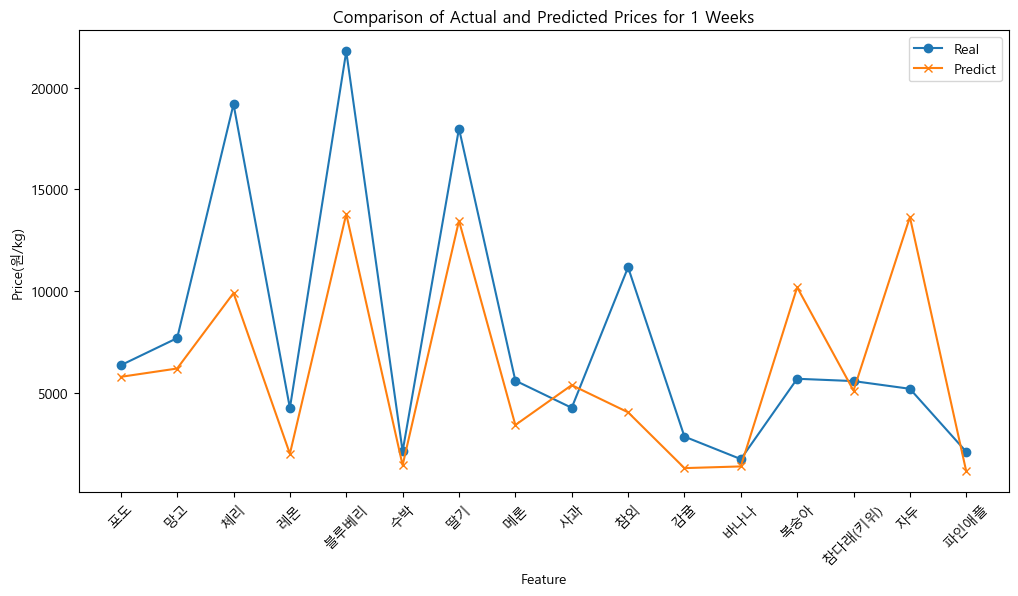


Results for 2 weeks:
Mean Absolute Error (MAE): 3794.8829405434362
Mean Squared Error (MSE): 30521462.427154154
Root Mean Squared Error (RMSE): 5524.623283732037
R² Score: 0.366945824149313


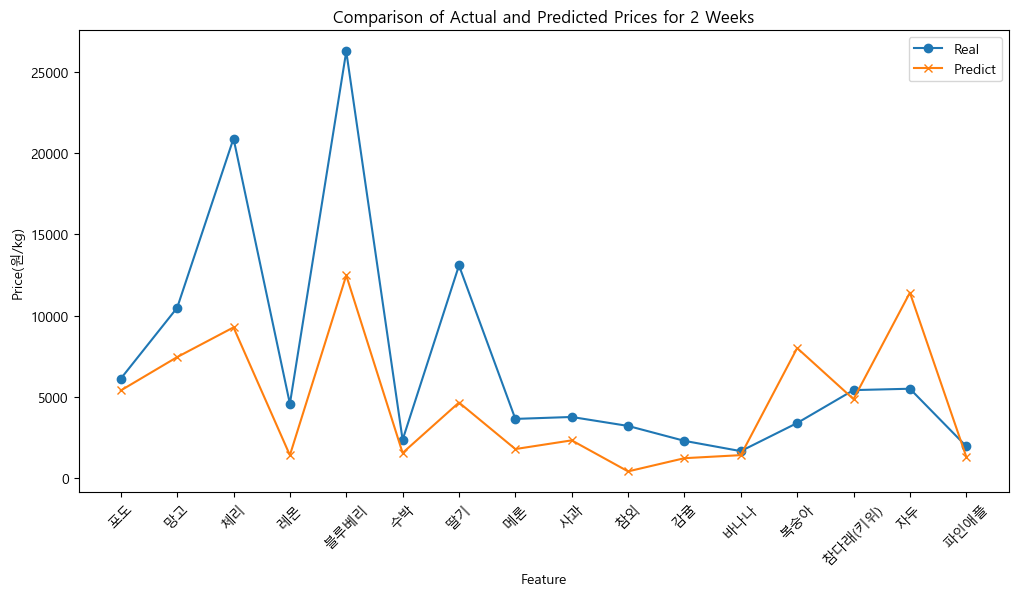


Results for 4 weeks:
Mean Absolute Error (MAE): 3505.5431476834674
Mean Squared Error (MSE): 37624666.11829052
Root Mean Squared Error (RMSE): 6133.894857127119
R² Score: 0.41423438834428294


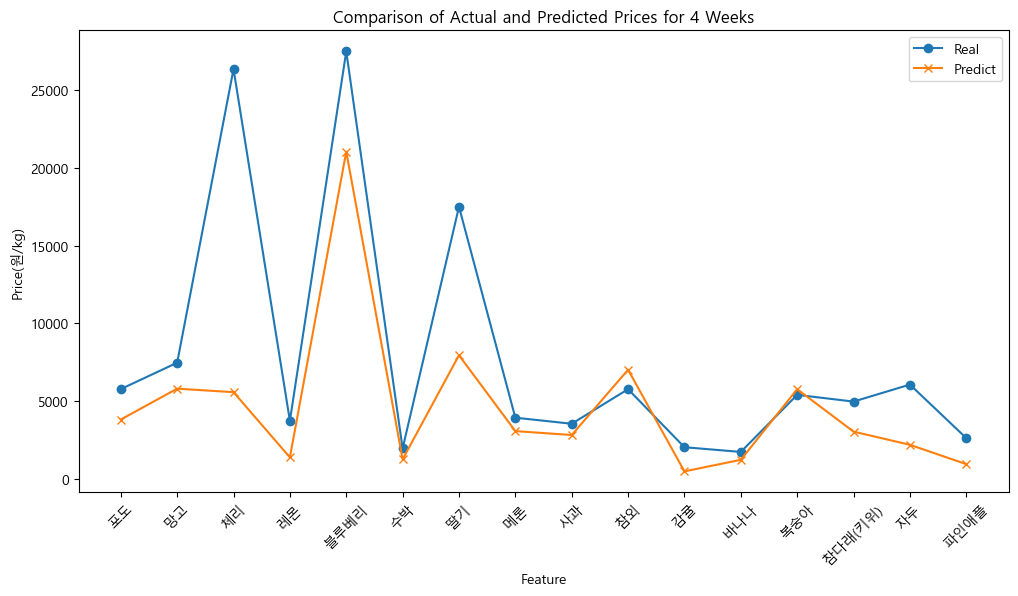

In [17]:
weeks = [1, 2, 4]
features = ['포도', '망고', '체리', '레몬', '블루베리', '수박', '딸기', '메론', 
            '사과', '참외', '감귤', '바나나', '복숭아', '참다래(키위)', '자두', '파인애플']

results = {week: {'features': [], 'predictions': [], 'actuals': []} for week in weeks}

for week in weeks:
    print(f"Processing for {week} weeks")
    for feature in features:
        my_fruit = Fruit(df)
        my_fruit.set_feature(feature)
        my_fruit.set_target(week)
        my_fruit.set_model()
        
        predicted_price = my_fruit.get_price()
        
        last_known_index = len(my_fruit.df) - 1
        actual_price = my_fruit.df.loc[last_known_index, my_fruit.name1]
        
        results[week]['features'].append(feature)
        results[week]['predictions'].append(predicted_price)
        results[week]['actuals'].append(actual_price)
        
        print(f"Feature: {feature}, Predicted Price: {predicted_price}, Actual Price: {actual_price}")

for week in weeks:
    features = results[week]['features']
    predictions = results[week]['predictions']
    actuals = results[week]['actuals']
    
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    
    print(f"\nResults for {week} weeks:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R² Score: {r2}")
    
    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(actuals)), actuals, label='Real', marker='o')
    plt.plot(range(len(predictions)), predictions, label='Predict', marker='x')
    plt.title(f'Comparison of Actual and Predicted Prices for {week} Weeks')
    plt.xlabel('Feature')
    plt.ylabel('Price(원/kg)')
    plt.xticks(ticks=range(len(features)), labels=features, rotation=45)
    plt.legend()
    plt.show()